## **Land Value Prediction Model**
- Author: Kim Dohwan [@ehghks021203](https://github.com/ehghks021203)
- Date: 2023.09.10. ~
- Description: Land value prediction model with XGBoost.
------

## **Overview**
In this project, we developed a predictive model for estimating land value, utilizing the XGBoost algorithm.

### Key Steps:
**1. Load libraries & get data:**

**2. Data Analysis:**
- In-depth analysis of the collected dataset.

**3. Data Preprocessing:**
- Handling missing values, encoding categorical variables, and scaling numerical features.

**4. Model Training with XGBoost:**
- Utilizing the XGBoost algorithm for training the predictive model.

**5. Evaluation and Validation:**
- Assessing model performance using metrics like Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE).

**6. Hyperparameter Tuning:**
- Fine-tuning model parameters for optimization.

### **Load libraries & get data**

In [1]:
# progress bar
from tqdm import trange, notebook

# linear algebra
import numpy as np 

# data processing
import pandas as pd
pd.options.display.float_format = "{: .2f}".format

# data visualization
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
sns.set(style="white", context="notebook", palette="deep")

# 그래프 글자 깨짐 문제 해결
plt.rcParams["axes.unicode_minus"] = False
fe = fm.FontEntry(
    fname=r"/usr/share/fonts/truetype/nanum/NanumGothic.ttf",   # ttf 파일이 저장되어 있는 경로
    name="NanumGothic"
)
fm.fontManager.ttflist.insert(0, fe)
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumGothic'}) # 폰트 설정

# Preprocessing
from sklearn.model_selection import train_test_split

# Data analysis
from scipy.stats import kstest
from scipy.stats import skew, norm


In [2]:
# Load Train Dataset
DATA_PATH = "../data/seoul_data_add_place_500.csv"
df = pd.read_csv(DATA_PATH)

# 실거래가 데이터 면적당 가격으로 환산 후 실수형 자료형으로 변경
df["DealAmount"] = df.DealAmount.str.replace(",", "").astype("float64") * 10000 / df["LndpclAr"]

# PNU 코드 자료형 object로 변경
df["PNU"] = df["PNU"].astype("str")
# PNU 코드를 시/도, 시/군/구, 읍/면/동, 리로 분할
df.insert(loc=1,column="Sido",value=df["PNU"].str.slice(0, 2).astype("object"))
df.insert(loc=2,column="Sigungu",value=df["PNU"].str.slice(2, 5).astype("object"))
df.insert(loc=3,column="Eupmyeondong",value=df["PNU"].str.slice(5, 8).astype("object"))
df.insert(loc=4,column="Ri",value=df["PNU"].str.slice(8, 10).astype("object"))
df.drop(["PNU", "LdCodeNm"], axis=1, inplace=True)

### **Data analysis**

Minimum Close Price: 33,488
Median Close Price : 13,856,322
Maximum Close Price: 192,307,692


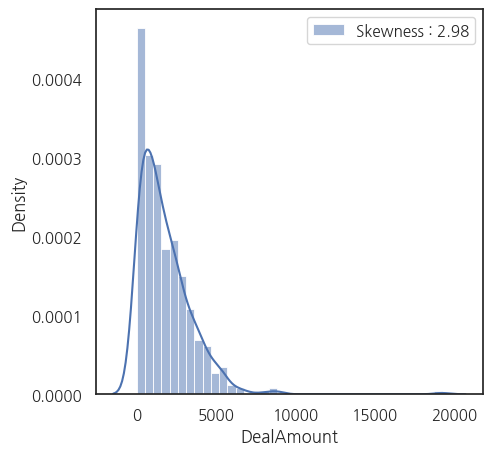

In [3]:
# target frature에 대한 분석
plt.subplots(figsize=(5,5))
g = sns.histplot(
    df["DealAmount"] / 10000, 
    kde=True,
    stat="density",
    kde_kws=dict(cut=3),
    label="Skewness : %.2f"%(df["DealAmount"].skew())
)
g = g.legend(loc="best")
print("Minimum Close Price: {:,.0f}".format(df["DealAmount"].min()))
print("Median Close Price : {:,.0f}".format(df["DealAmount"].median()))
print("Maximum Close Price: {:,.0f}".format(df["DealAmount"].max()))

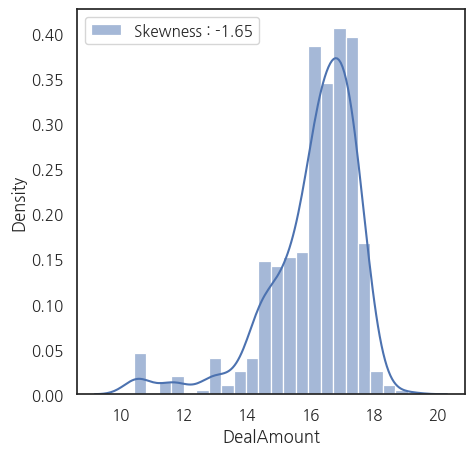

In [4]:
plt.subplots(figsize=(5, 5))
g = sns.histplot(
    np.log1p(df["DealAmount"]), 
    kde=True,
    stat="density",
    kde_kws=dict(cut=3),
    label = "Skewness : %.2f"%(np.log1p(df["DealAmount"]).skew())
)
g = g.legend(loc="best")

<Axes: ylabel='DealAmount'>

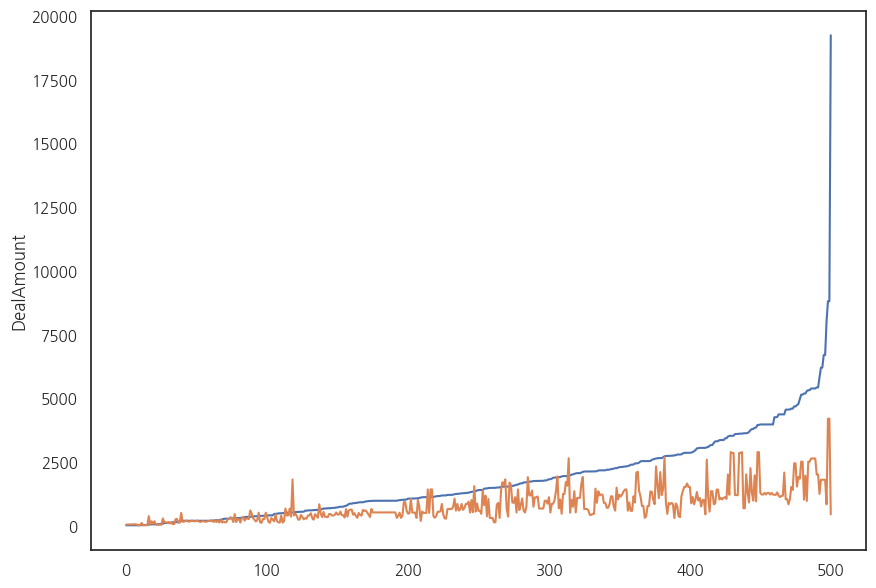

In [5]:
df_price = df[["DealAmount", "PblntfPclnd"]]
df_price = df_price.sort_values("DealAmount").reset_index(drop=True)

plt.subplots(figsize=(10, 7))
sns.lineplot(df_price["DealAmount"]/10000)
sns.lineplot(df_price["PblntfPclnd"]/10000)

<Axes: ylabel='DealAmount'>

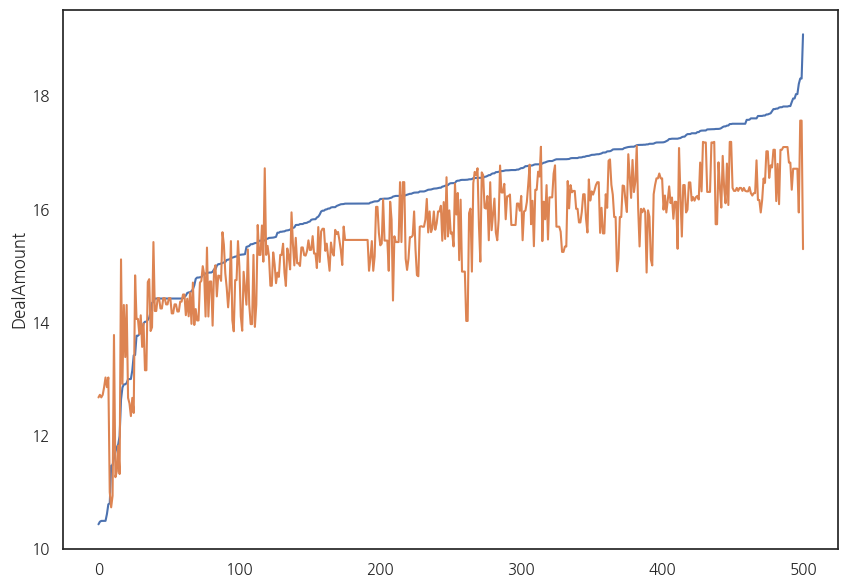

In [6]:
plt.subplots(figsize=(10, 7))
sns.lineplot(np.log1p(df_price["DealAmount"]))
sns.lineplot(np.log1p(df_price["PblntfPclnd"]))

In [7]:
#df["DealAmount"] = np.log1p(df["DealAmount"])
#df["PblntfPclnd"] = np.log1p(df["PblntfPclnd"])

In [8]:
# 범주형 변수에 대한 데이터 분석
categorical = [var for var in df.columns if df[var].dtype=='O']  # 범주형 변수 추출
print(categorical)

['Sido', 'Sigungu', 'Eupmyeondong', 'Ri', 'RegstrSeCodeNm', 'LndcgrCodeNm', 'PrposAreaNm', 'LadUseSittnNm', 'TpgrphHgCodeNm', 'TpgrphFrmCodeNm', 'RoadSideCodeNm', 'PrposAreaDstrcCodeNm']


<Axes: xlabel='Sido', ylabel='DealAmount'>

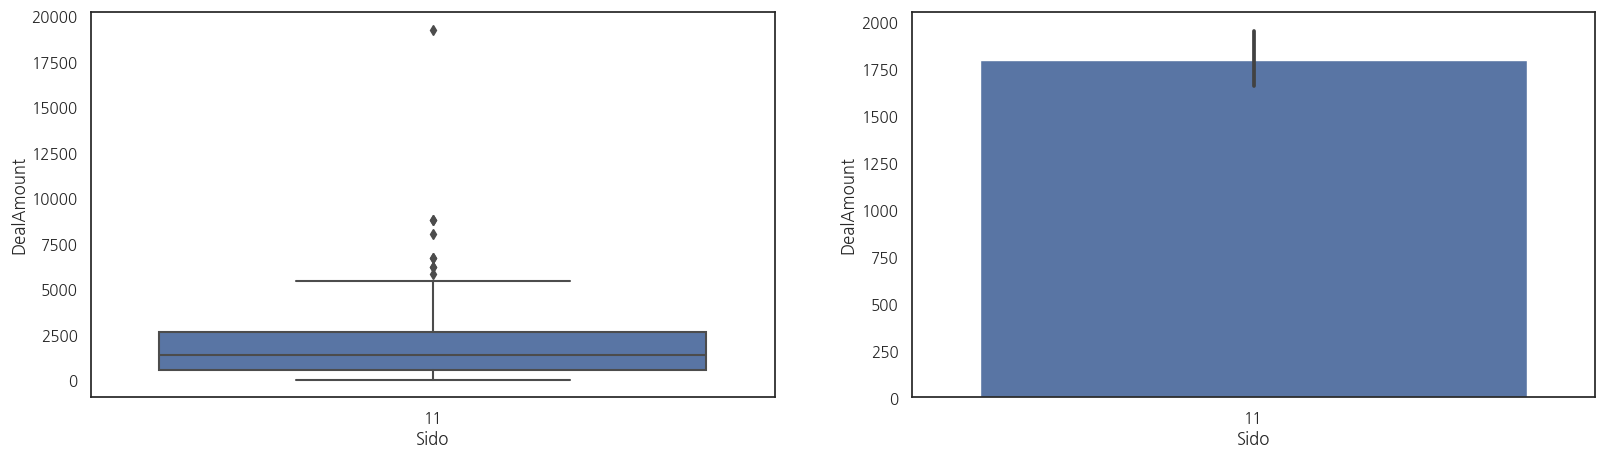

In [9]:
plt.subplots(figsize=(30,5))
plt.clf()
plt.subplot(1, 3, 1)
sns.boxplot(x=df[categorical[0]], y=df["DealAmount"]/10000)
plt.subplot(1, 3, 2)
sns.barplot(x=df[categorical[0]], y=df["DealAmount"]/10000)

In [10]:
# 연속형 변수에 대한 데이터 분석
numerical = [var for var in df.columns if df[var].dtype!="O"]  # 연속형 변수 추출
print(numerical)

['DealAmount', 'DealMonth', 'Year', 'LndpclAr', 'PblntfPclnd', 'Tot_ppltn', 'Avg_age', 'Ppltn_dnsty', 'Aged_child_idx', 'Oldage_suprt_per', 'Juv_suprt_per', 'Tot_family', 'Avg_fmember_cnt', 'Tot_house', 'Corp_cnt', 'Tot_worker', 'ChangePricePercent', 'ChangePricePercentTotal', 'ChangePricePercentAverage', 'LandPlace_MT1', 'LandPlace_CS2', 'LandPlace_PS3', 'LandPlace_SC4', 'LandPlace_AC5', 'LandPlace_PK6', 'LandPlace_OL7', 'LandPlace_SW8', 'LandPlace_BK9', 'LandPlace_CT1', 'LandPlace_AG2', 'LandPlace_PO3', 'LandPlace_AT4', 'LandPlace_AD5', 'LandPlace_FD6', 'LandPlace_CE7', 'LandPlace_HP8', 'LandPlace_PM9', 'LandPlace_MT1_500m', 'LandPlace_CS2_500m', 'LandPlace_PS3_500m', 'LandPlace_SC4_500m', 'LandPlace_AC5_500m', 'LandPlace_PK6_500m', 'LandPlace_OL7_500m', 'LandPlace_SW8_500m', 'LandPlace_BK9_500m', 'LandPlace_CT1_500m', 'LandPlace_AG2_500m', 'LandPlace_PO3_500m', 'LandPlace_AT4_500m', 'LandPlace_AD5_500m', 'LandPlace_FD6_500m', 'LandPlace_CE7_500m', 'LandPlace_HP8_500m', 'LandPlace_PM

<Axes: >

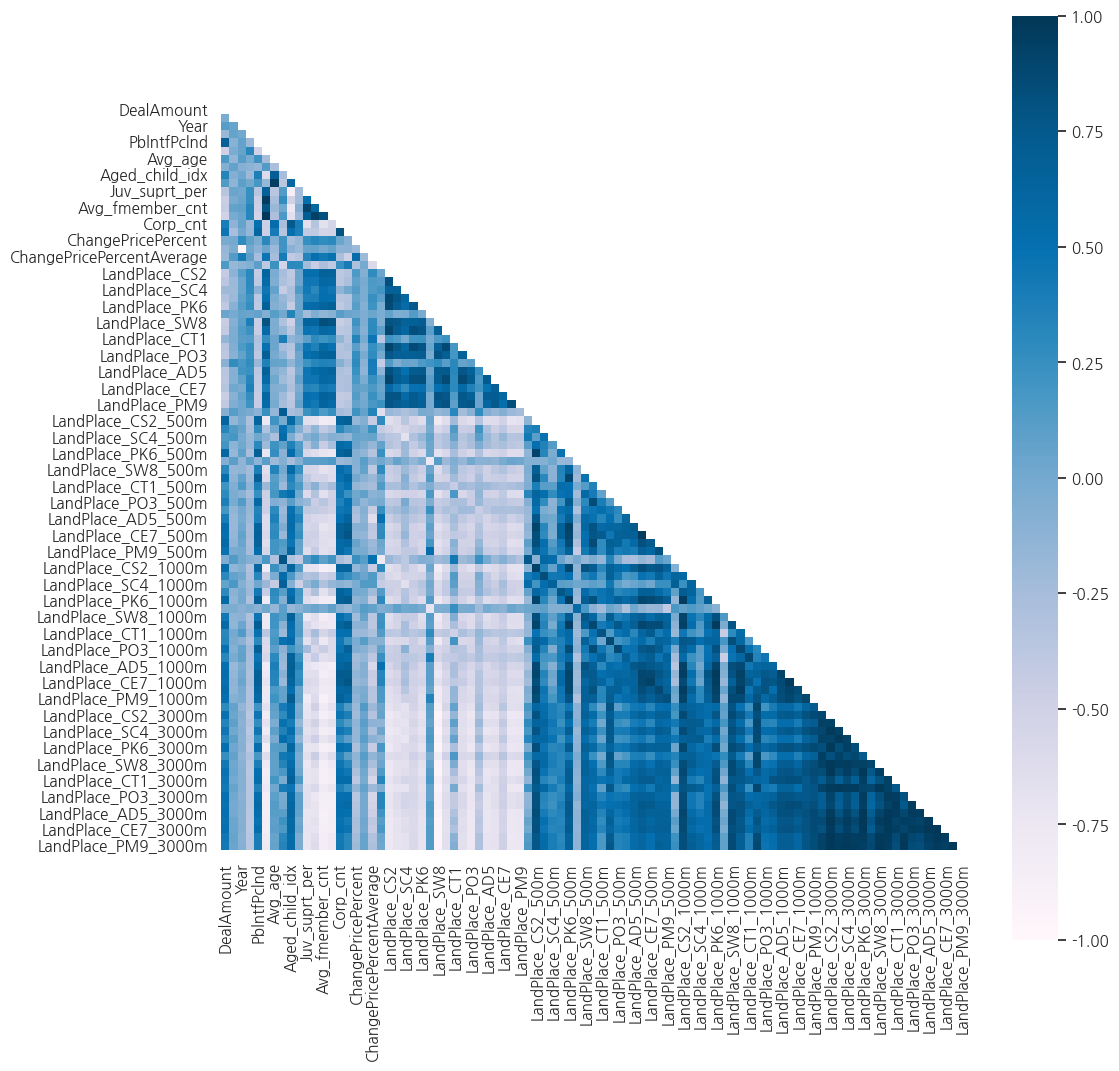

In [27]:
corr = df[numerical].corr(method="pearson")
mask_df = corr
colormap = plt.cm.PuBu

mask = np.zeros_like(mask_df, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
plt.subplots(figsize=(12, 12))
sns.heatmap(
    corr, 
    vmax=1.0,
    vmin=-1.0,
    square=True, 
    mask=mask,
    cmap=colormap, 
    linecolor="white"
)

DealAmount


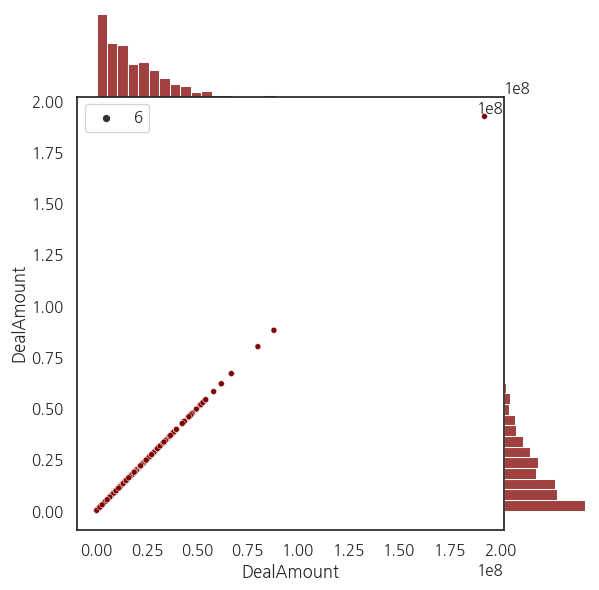

Number Of Missing Point
0
************************************************************
DealMonth


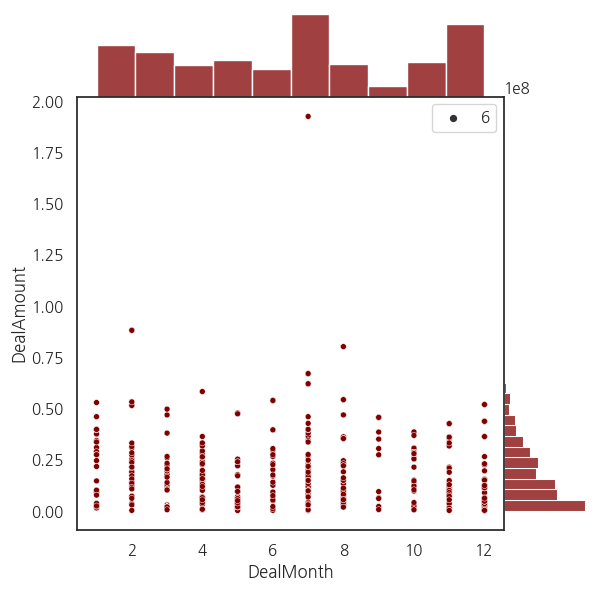

Number Of Missing Point
0
************************************************************
Year


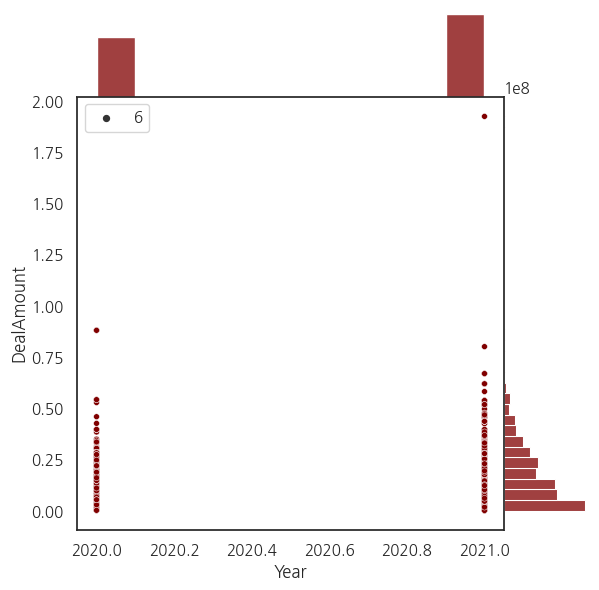

Number Of Missing Point
0
************************************************************
LndpclAr


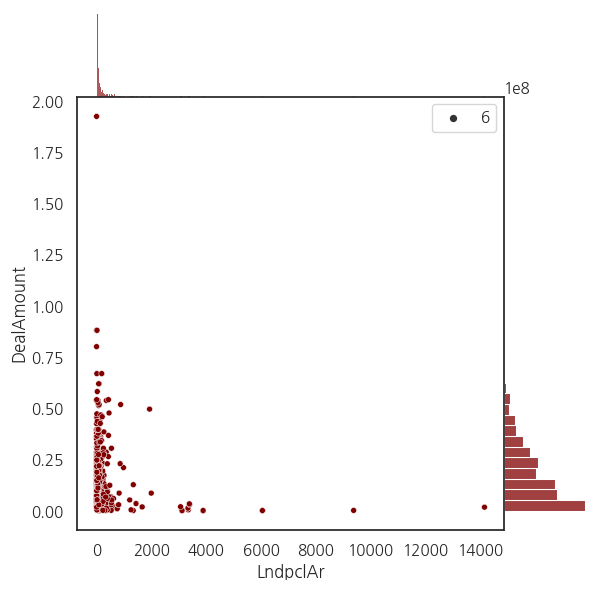

Number Of Missing Point
0
************************************************************
PblntfPclnd


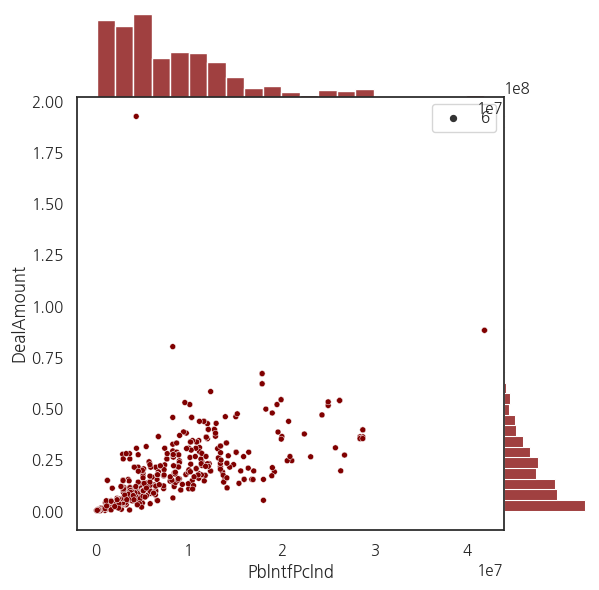

Number Of Missing Point
0
************************************************************
Tot_ppltn


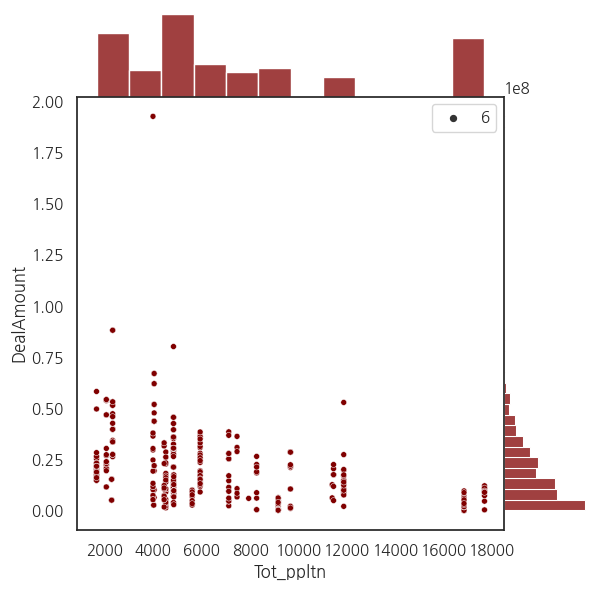

Number Of Missing Point
0
************************************************************
Avg_age


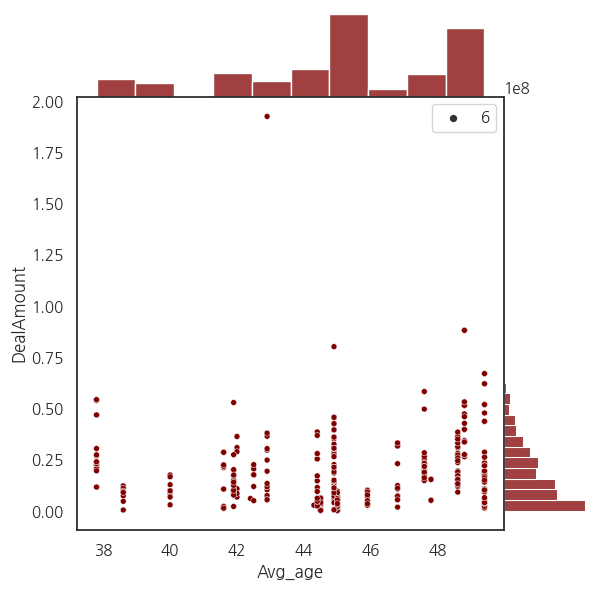

Number Of Missing Point
0
************************************************************
Ppltn_dnsty


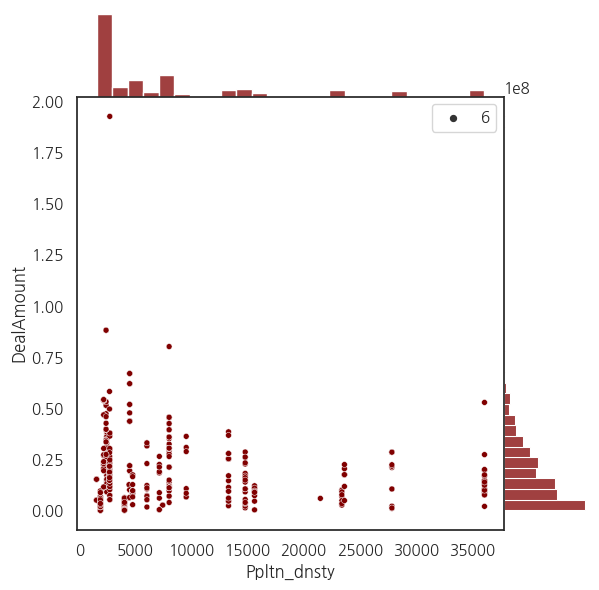

Number Of Missing Point
0
************************************************************
Aged_child_idx


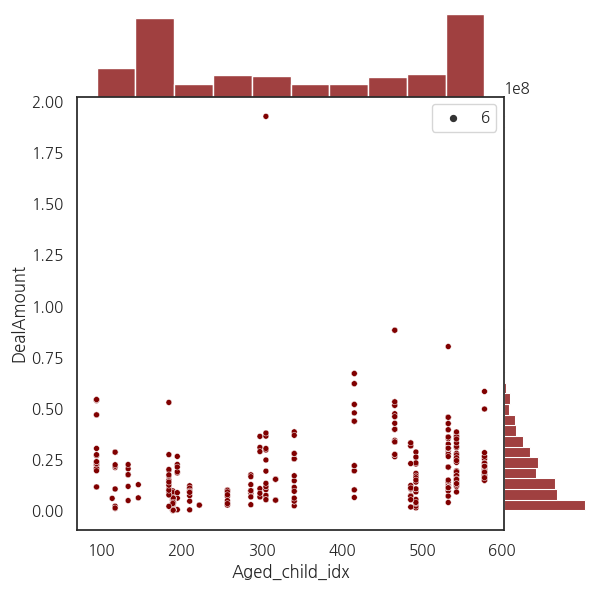

Number Of Missing Point
0
************************************************************
Oldage_suprt_per


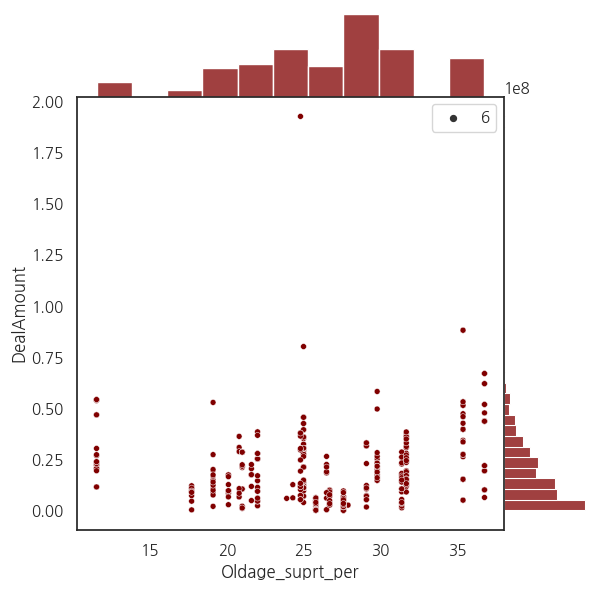

Number Of Missing Point
0
************************************************************
Juv_suprt_per


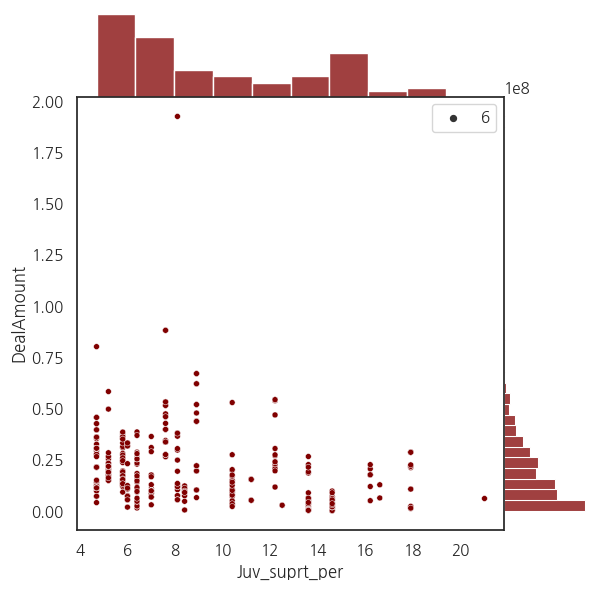

Number Of Missing Point
0
************************************************************
Tot_family


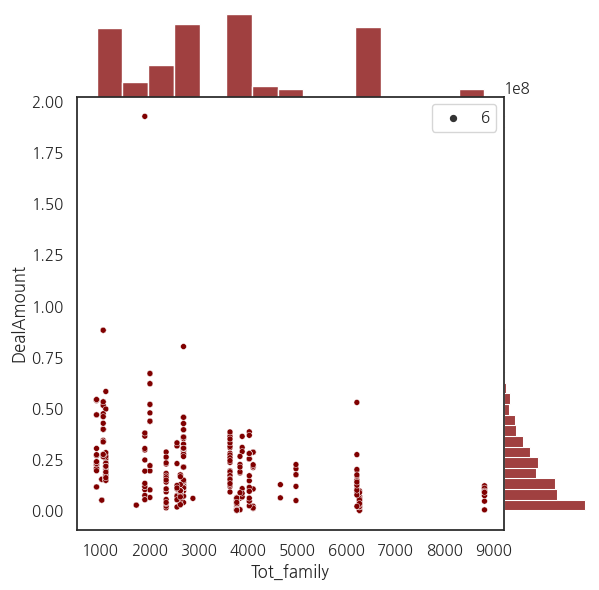

Number Of Missing Point
0
************************************************************
Avg_fmember_cnt


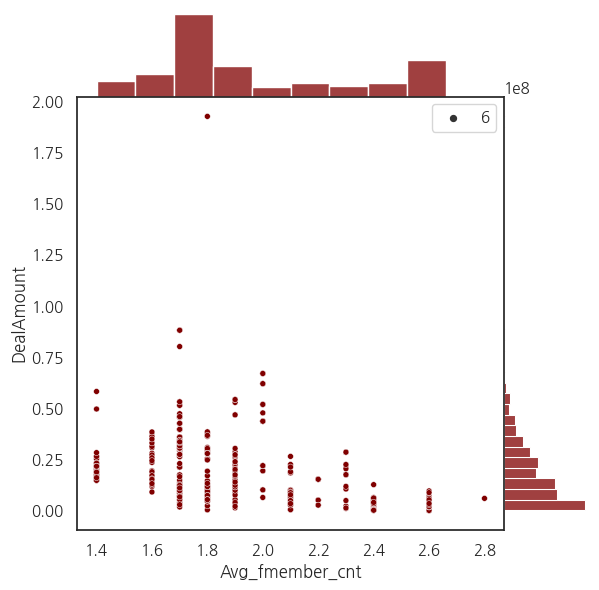

Number Of Missing Point
0
************************************************************
Tot_house


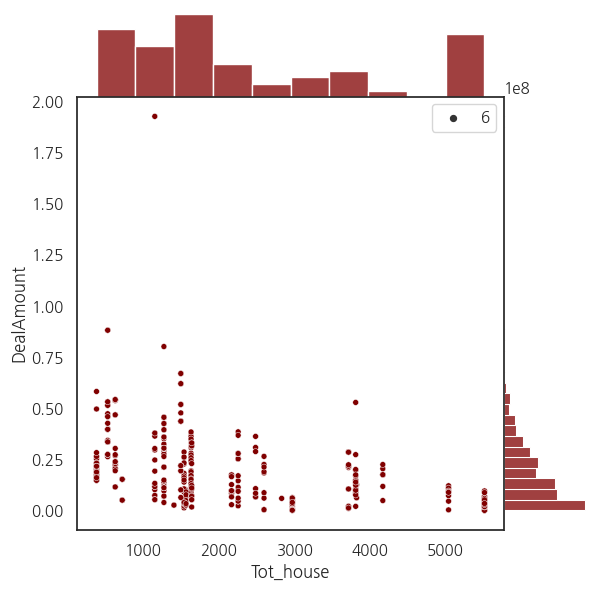

Number Of Missing Point
0
************************************************************
Corp_cnt


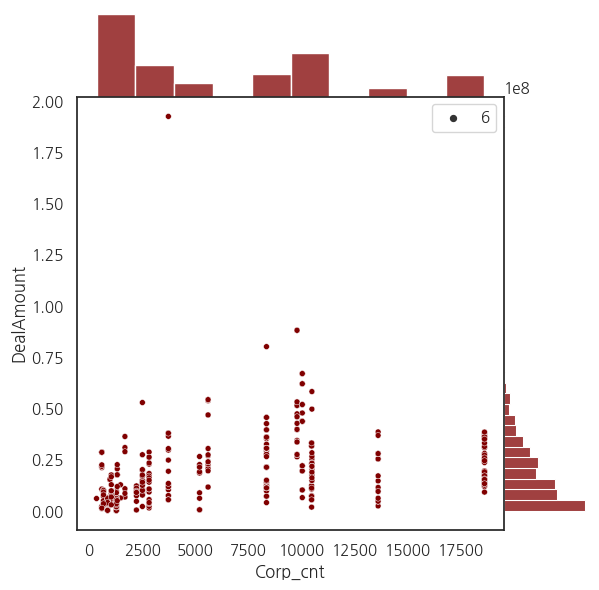

Number Of Missing Point
0
************************************************************
Tot_worker


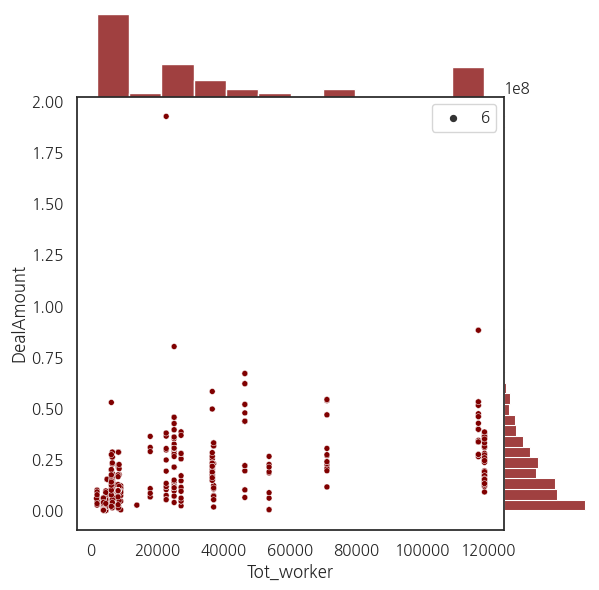

Number Of Missing Point
0
************************************************************
ChangePricePercent


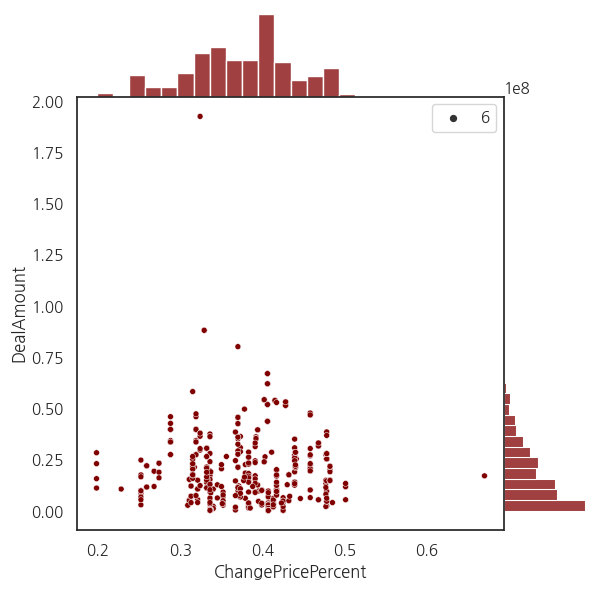

Number Of Missing Point
0
************************************************************
ChangePricePercentTotal


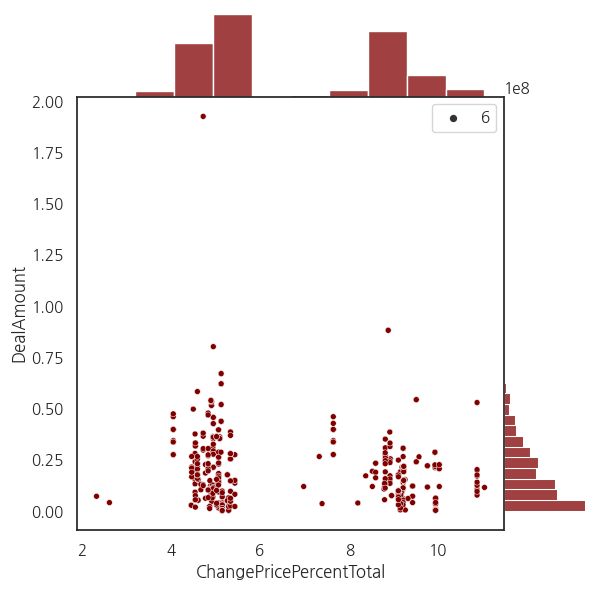

Number Of Missing Point
0
************************************************************
ChangePricePercentAverage


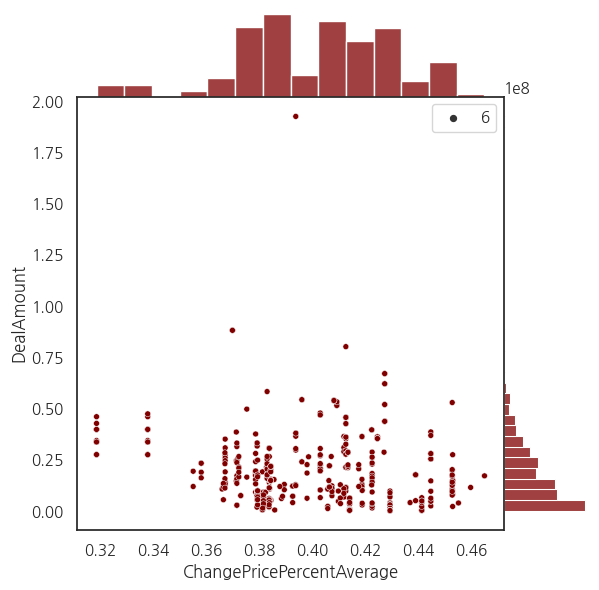

Number Of Missing Point
0
************************************************************
LandPlace_MT1


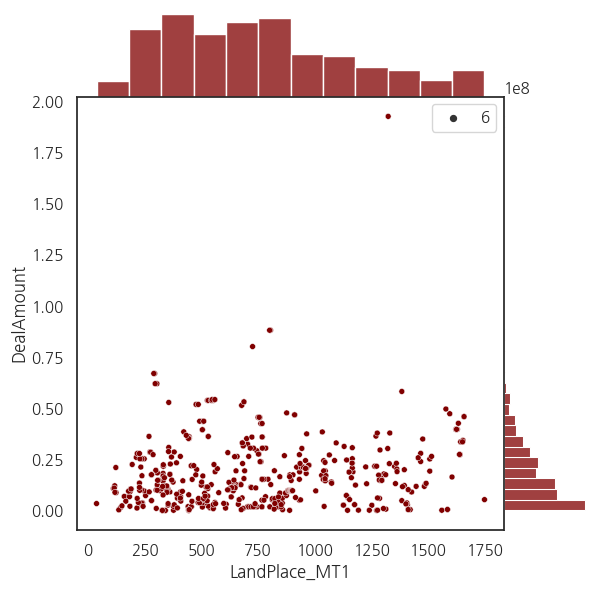

Number Of Missing Point
0
************************************************************
LandPlace_CS2


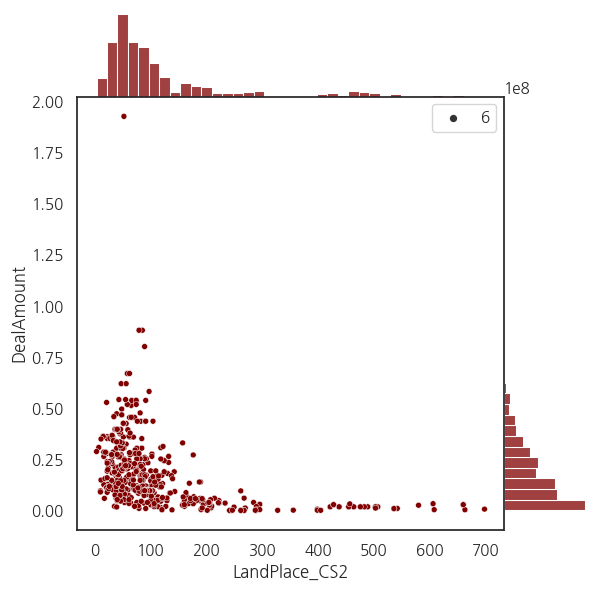

Number Of Missing Point
0
************************************************************
LandPlace_PS3


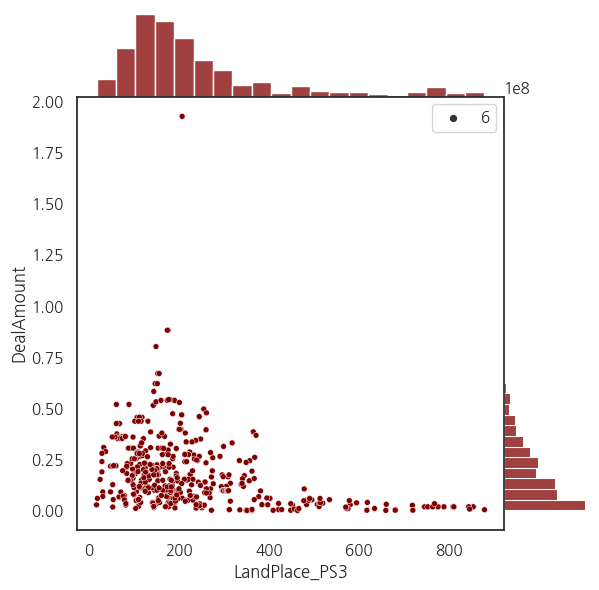

Number Of Missing Point
0
************************************************************
LandPlace_SC4


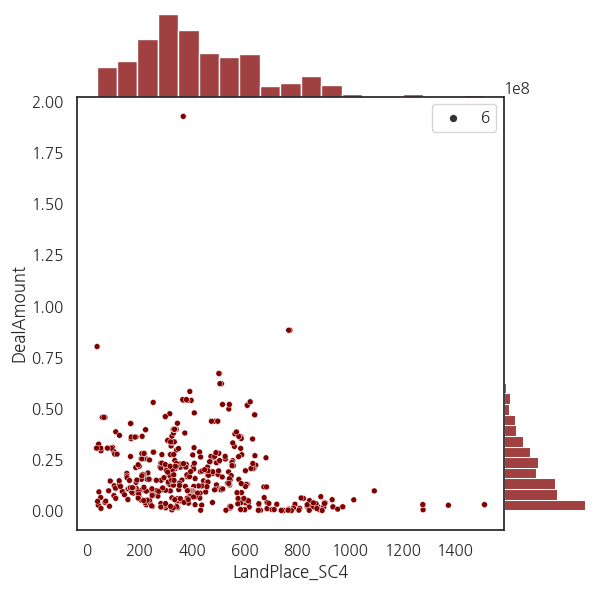

Number Of Missing Point
0
************************************************************
LandPlace_AC5


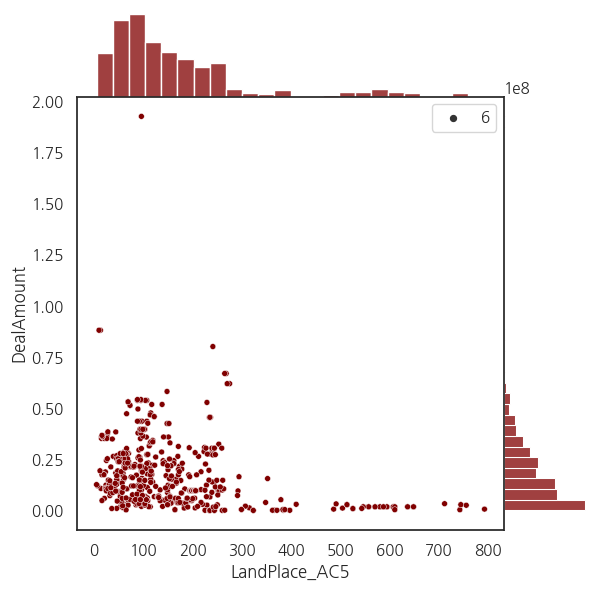

Number Of Missing Point
0
************************************************************
LandPlace_PK6


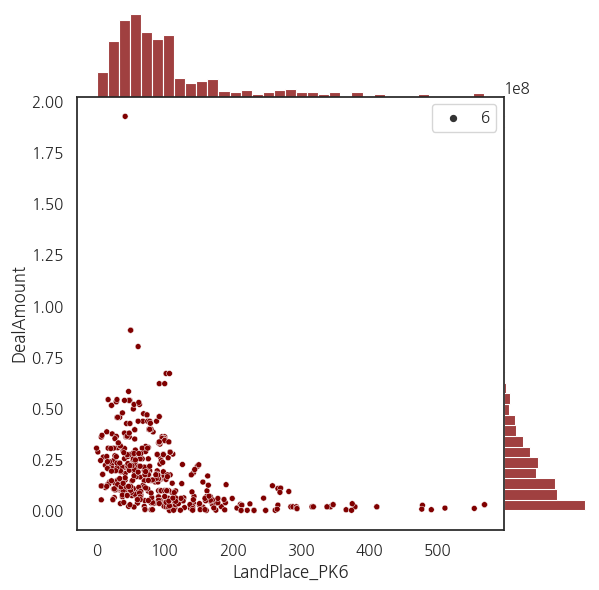

Number Of Missing Point
0
************************************************************
LandPlace_OL7


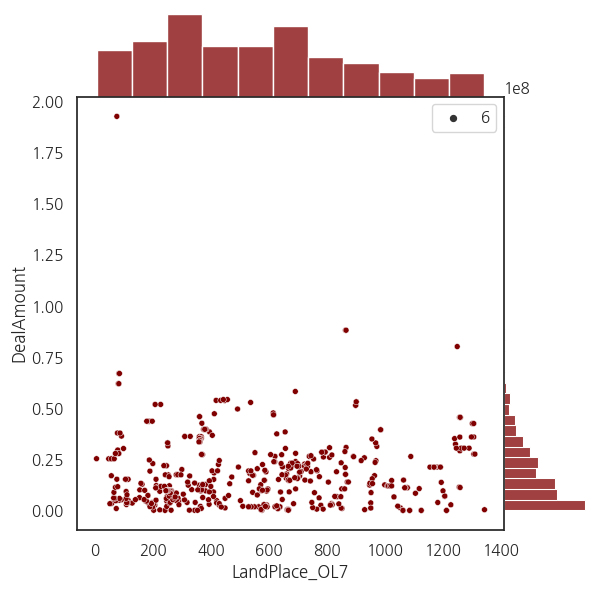

Number Of Missing Point
0
************************************************************
LandPlace_SW8


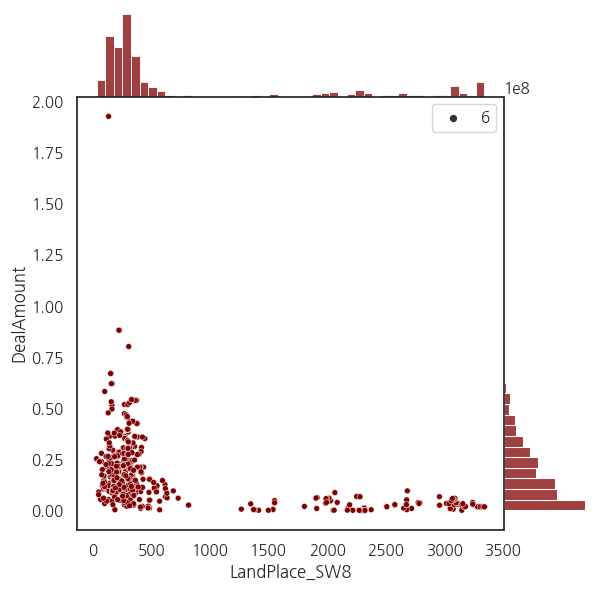

Number Of Missing Point
0
************************************************************
LandPlace_BK9


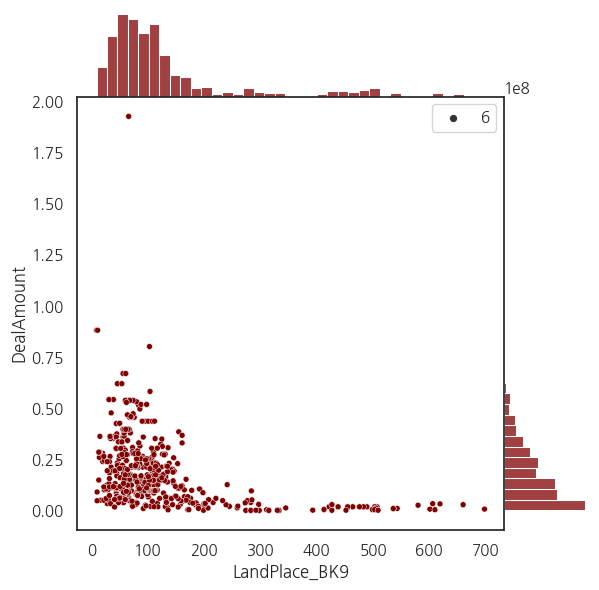

Number Of Missing Point
0
************************************************************
LandPlace_CT1


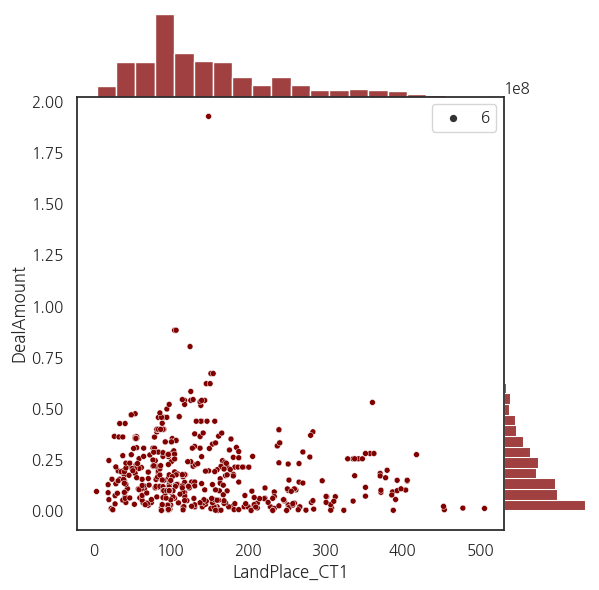

Number Of Missing Point
0
************************************************************
LandPlace_AG2


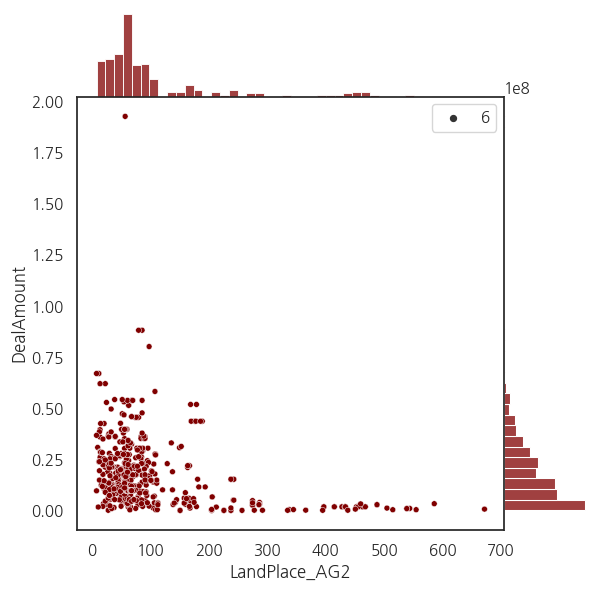

Number Of Missing Point
0
************************************************************
LandPlace_PO3


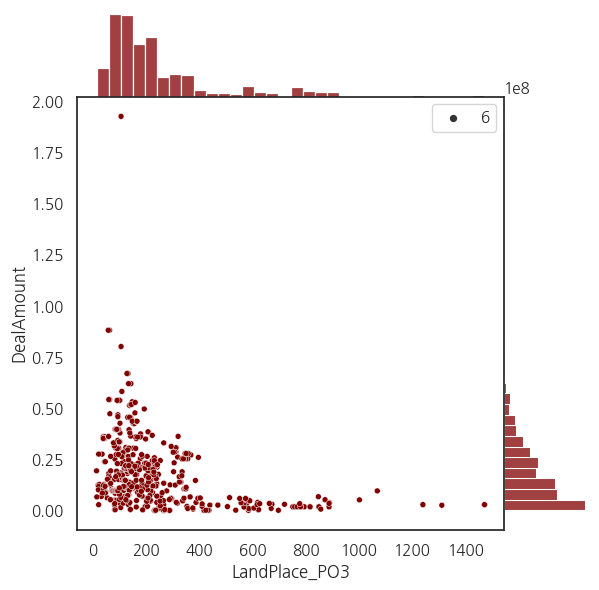

Number Of Missing Point
0
************************************************************
LandPlace_AT4


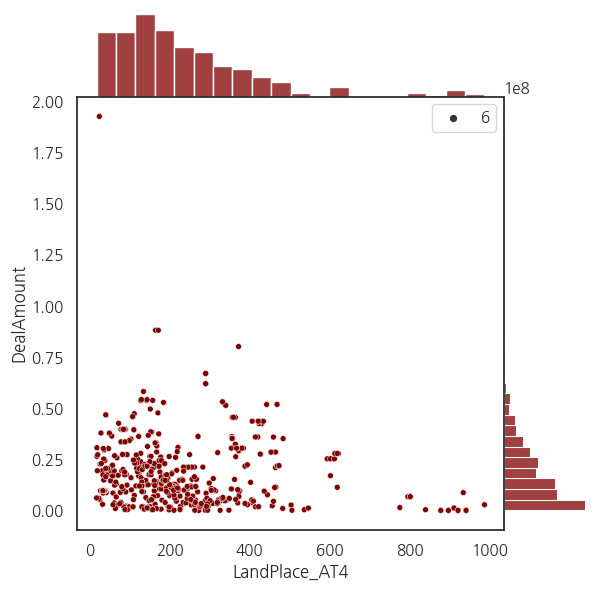

Number Of Missing Point
0
************************************************************
LandPlace_AD5


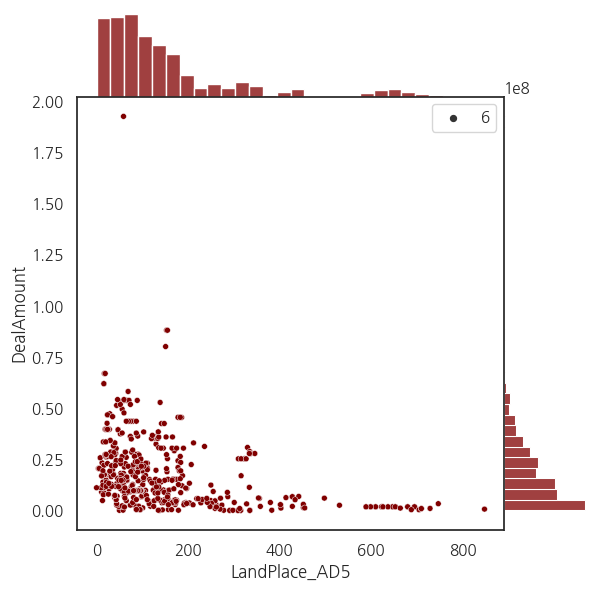

Number Of Missing Point
0
************************************************************
LandPlace_FD6


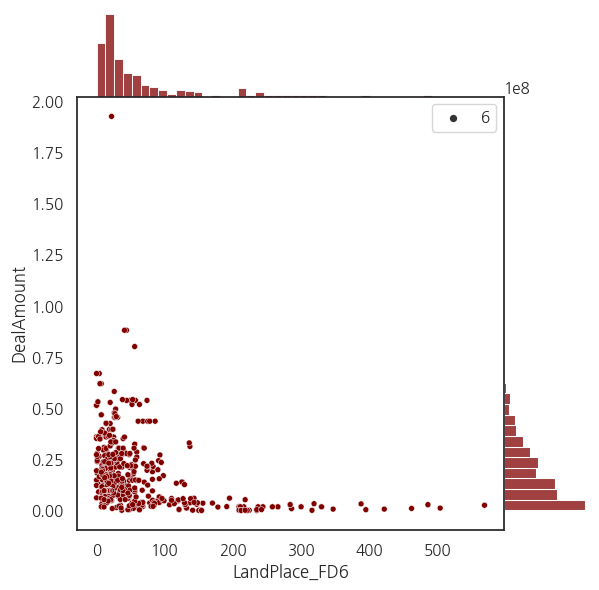

Number Of Missing Point
0
************************************************************
LandPlace_CE7


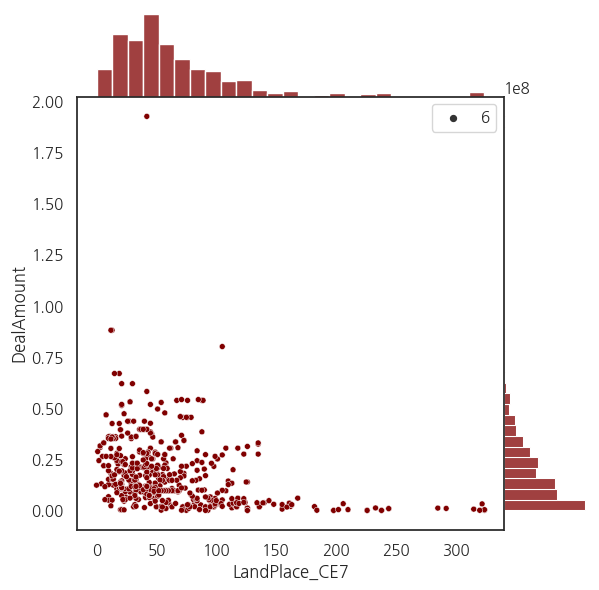

Number Of Missing Point
0
************************************************************
LandPlace_HP8


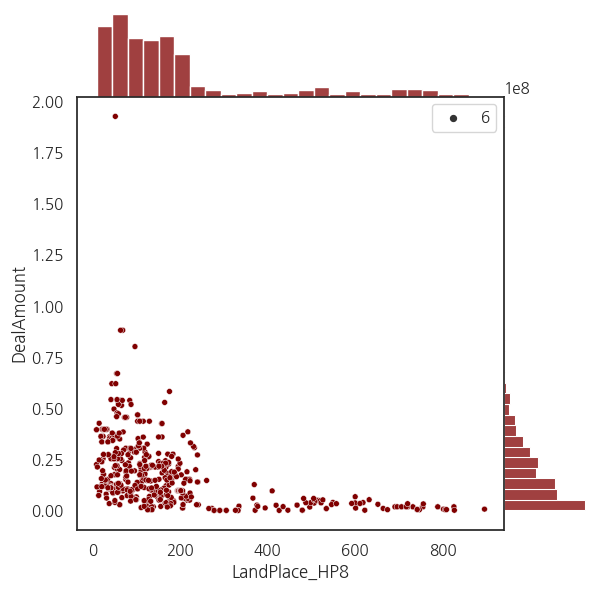

Number Of Missing Point
0
************************************************************
LandPlace_PM9


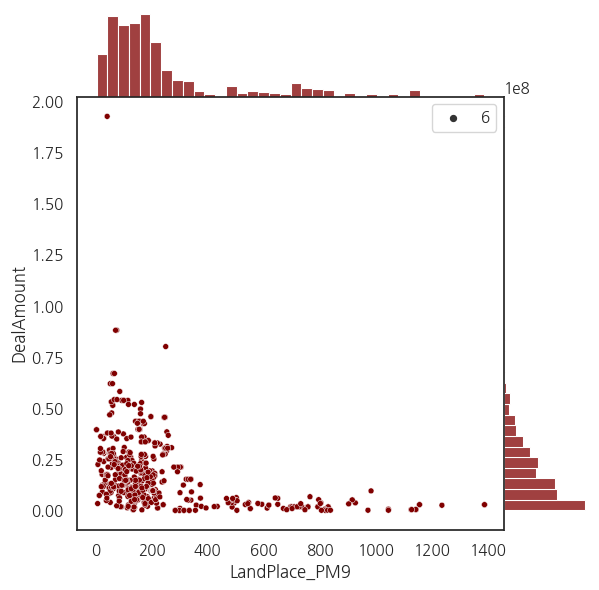

Number Of Missing Point
0
************************************************************
LandPlace_MT1_500m


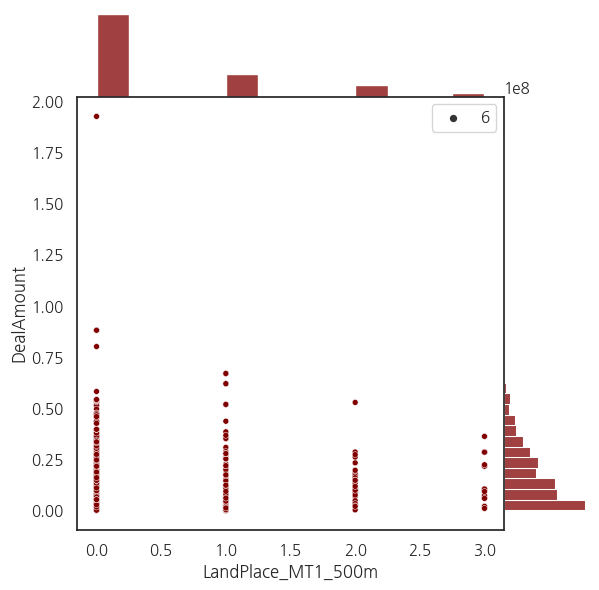

Number Of Missing Point
0
************************************************************
LandPlace_CS2_500m


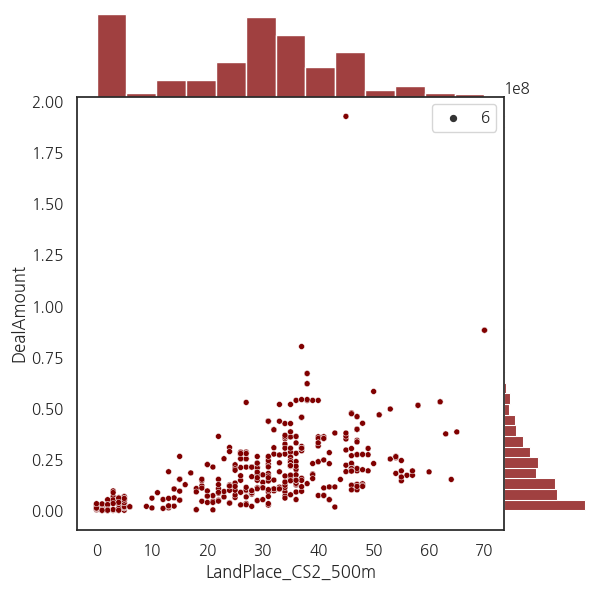

Number Of Missing Point
0
************************************************************
LandPlace_PS3_500m


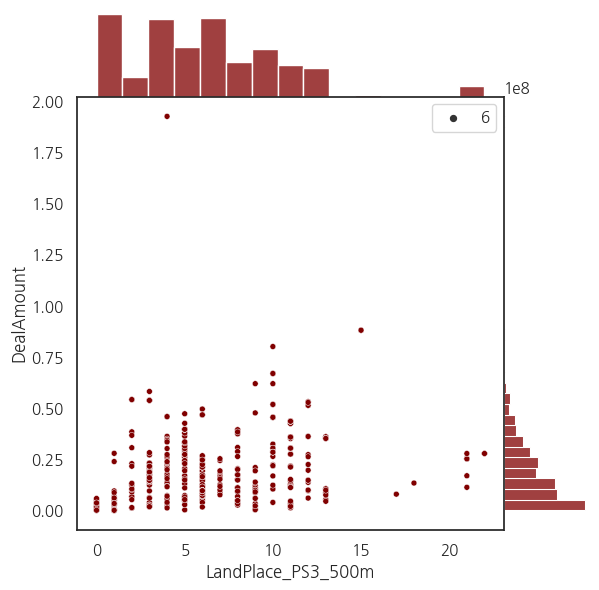

Number Of Missing Point
0
************************************************************
LandPlace_SC4_500m


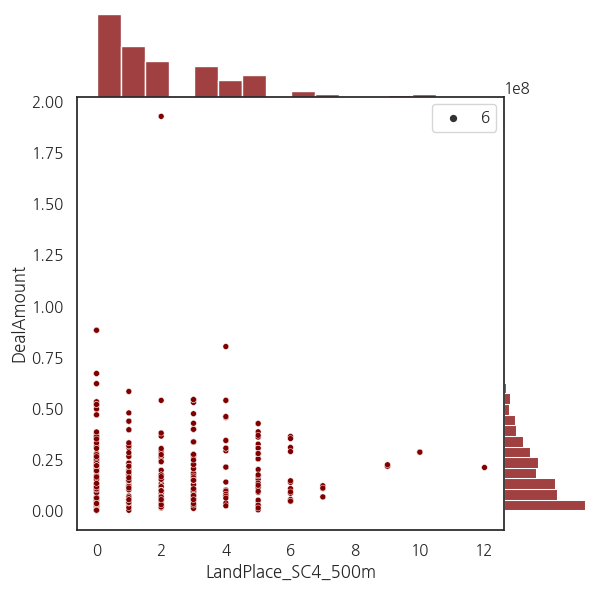

Number Of Missing Point
0
************************************************************
LandPlace_AC5_500m


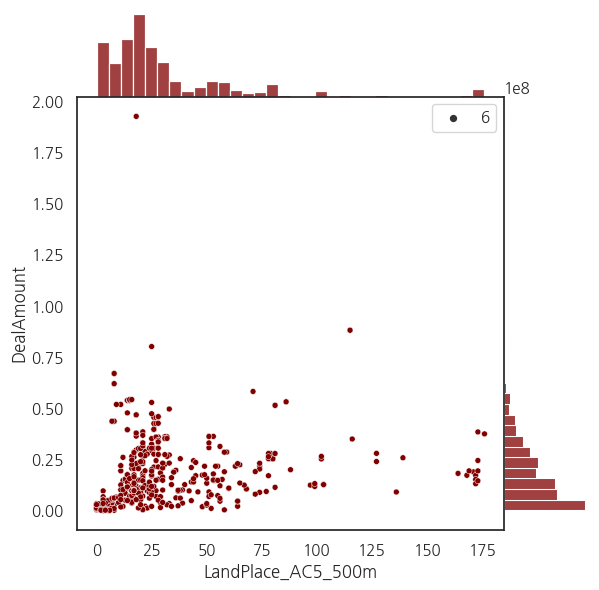

Number Of Missing Point
0
************************************************************
LandPlace_PK6_500m


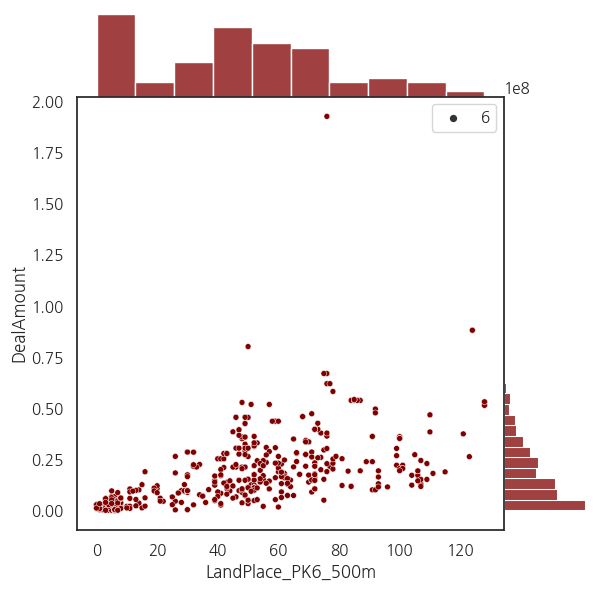

Number Of Missing Point
0
************************************************************
LandPlace_OL7_500m


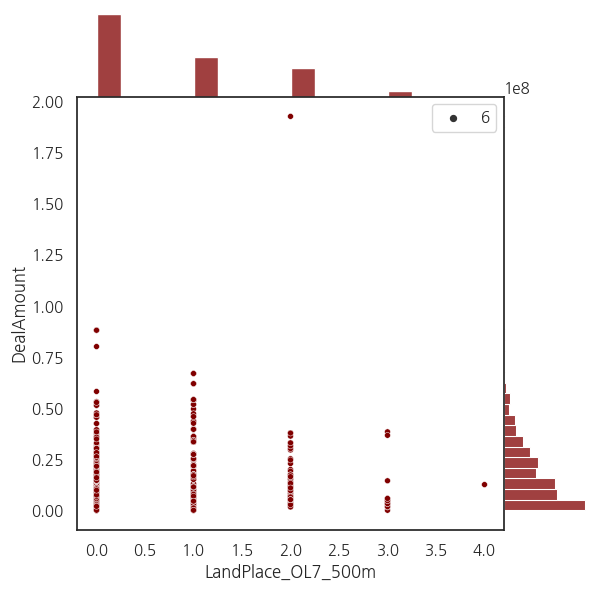

Number Of Missing Point
0
************************************************************
LandPlace_SW8_500m


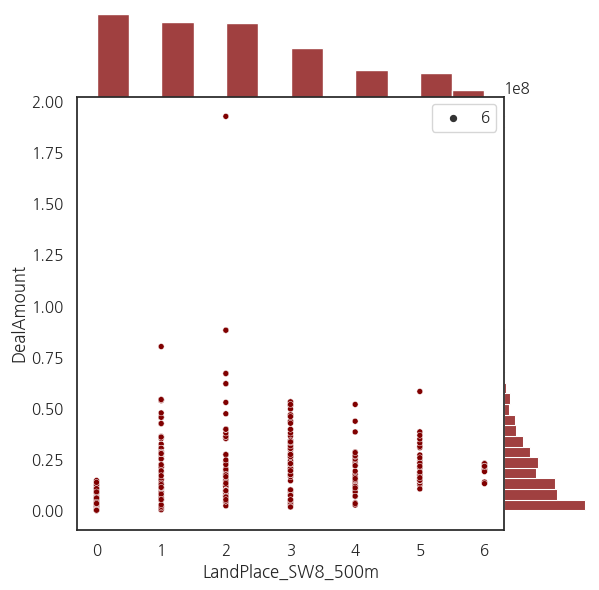

Number Of Missing Point
0
************************************************************
LandPlace_BK9_500m


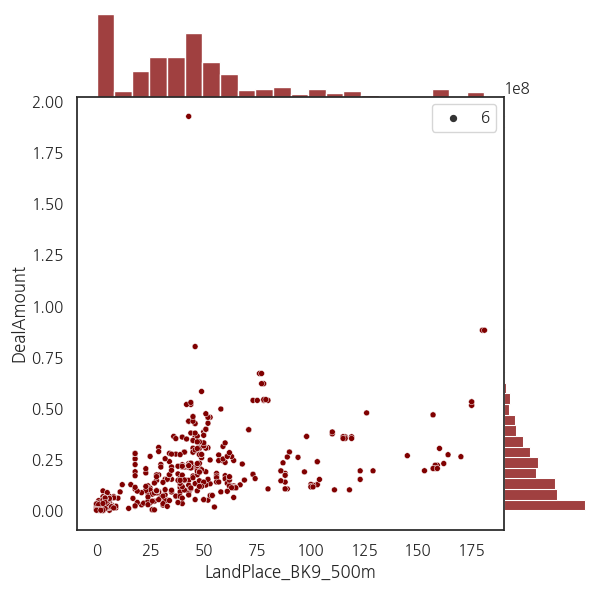

Number Of Missing Point
0
************************************************************
LandPlace_CT1_500m


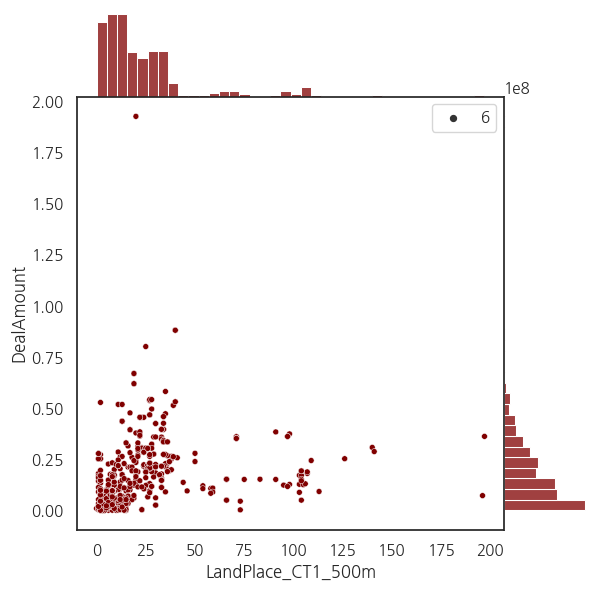

Number Of Missing Point
0
************************************************************
LandPlace_AG2_500m


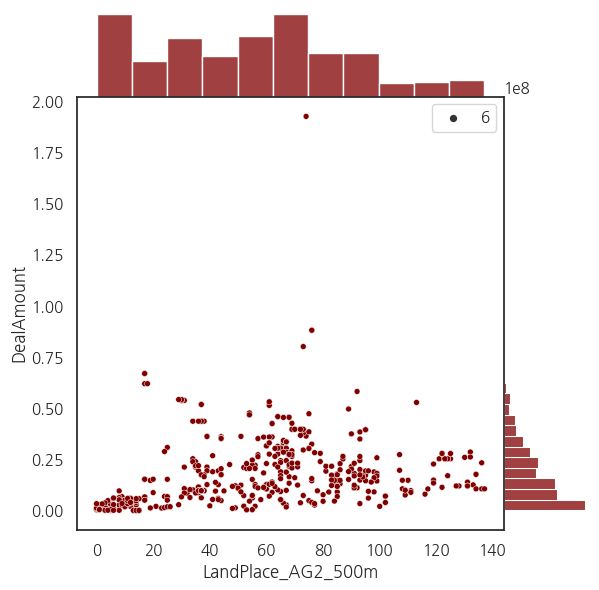

Number Of Missing Point
0
************************************************************
LandPlace_PO3_500m


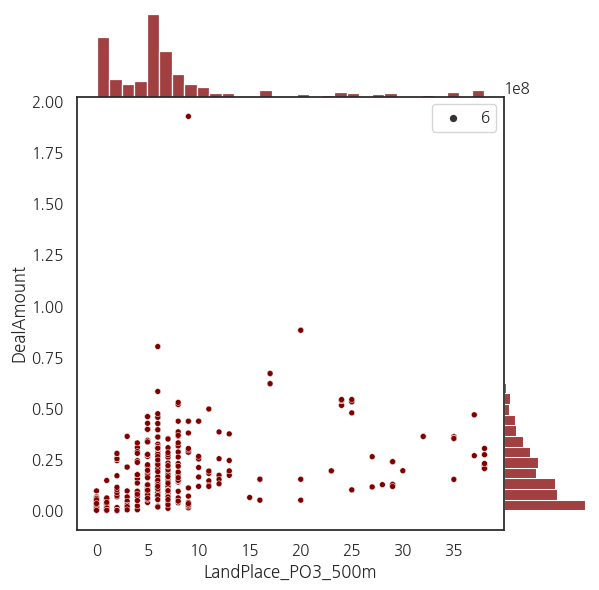

Number Of Missing Point
0
************************************************************
LandPlace_AT4_500m


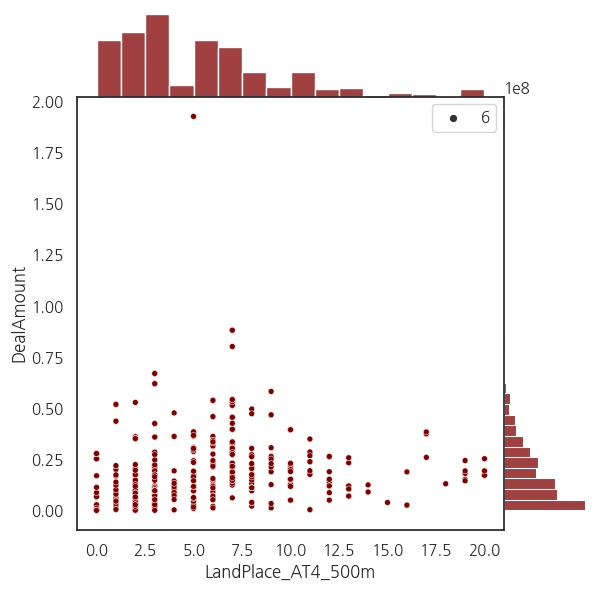

Number Of Missing Point
0
************************************************************
LandPlace_AD5_500m


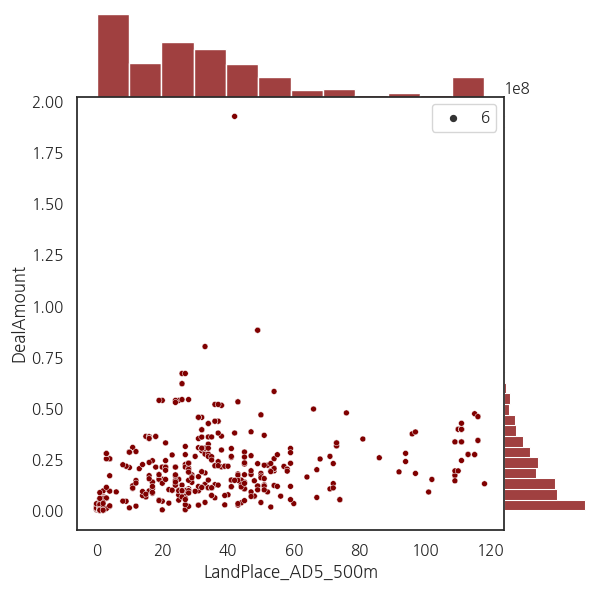

Number Of Missing Point
0
************************************************************
LandPlace_FD6_500m


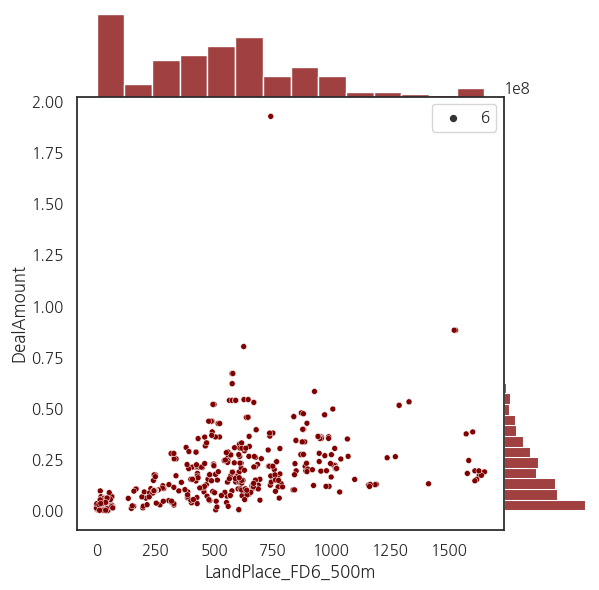

Number Of Missing Point
0
************************************************************
LandPlace_CE7_500m


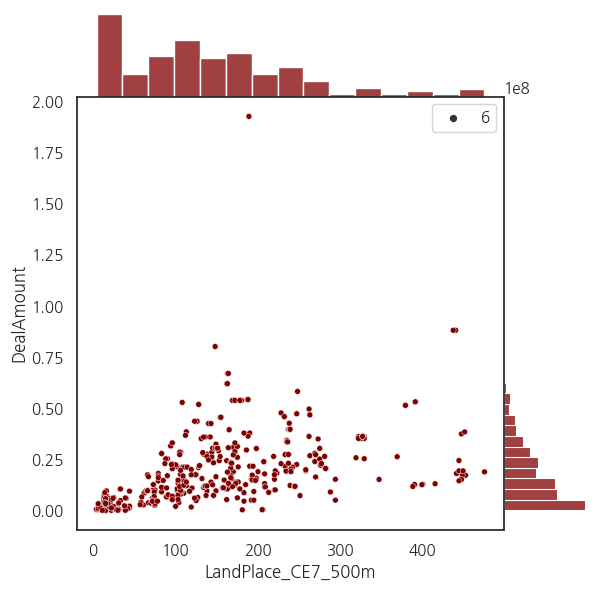

Number Of Missing Point
0
************************************************************
LandPlace_HP8_500m


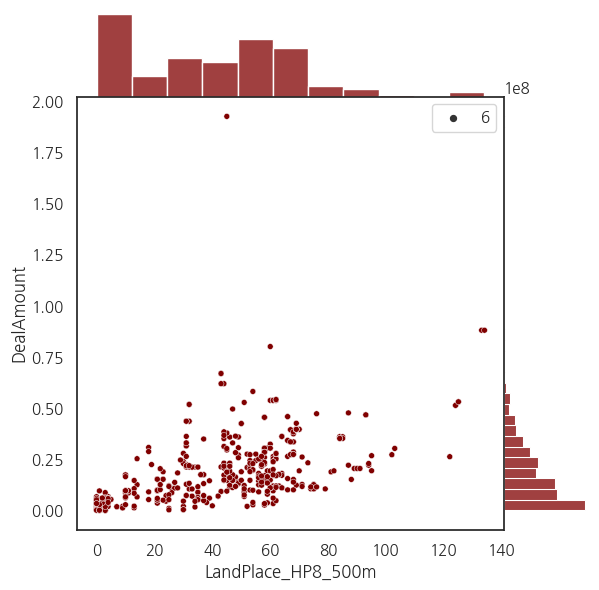

Number Of Missing Point
0
************************************************************
LandPlace_PM9_500m


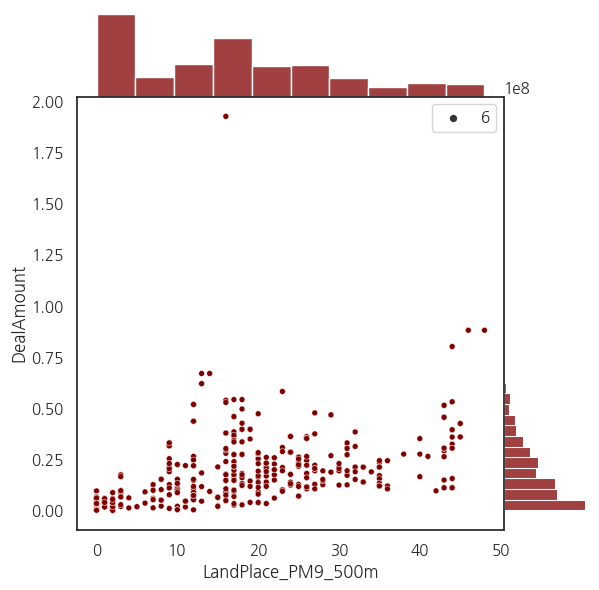

Number Of Missing Point
0
************************************************************
LandPlace_MT1_1000m


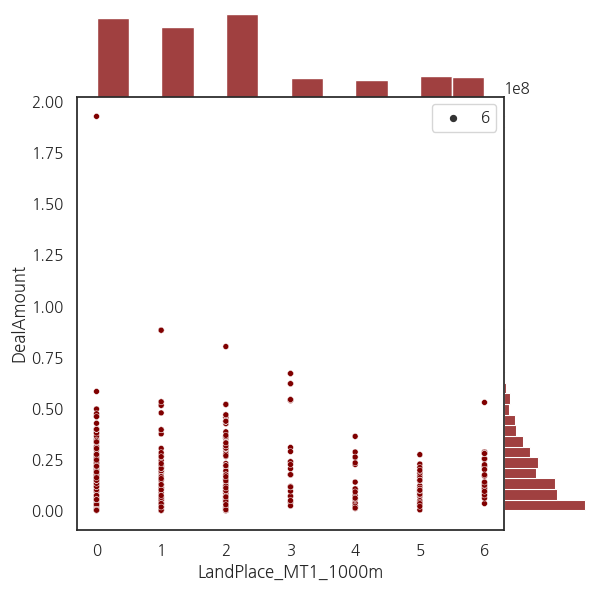

Number Of Missing Point
0
************************************************************
LandPlace_CS2_1000m


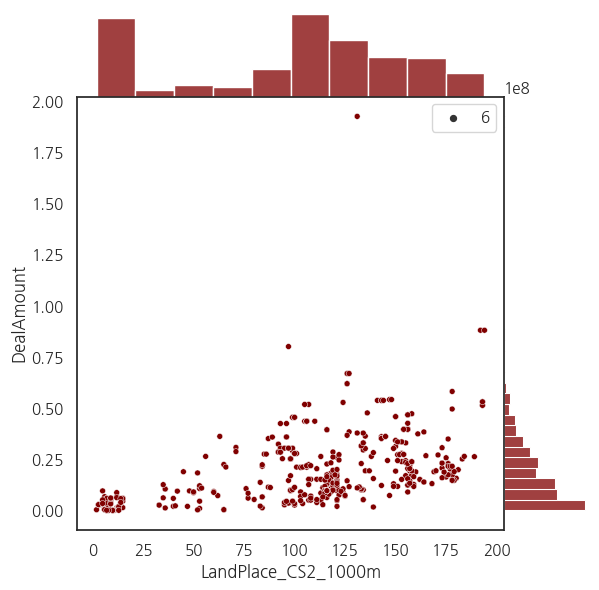

Number Of Missing Point
0
************************************************************
LandPlace_PS3_1000m


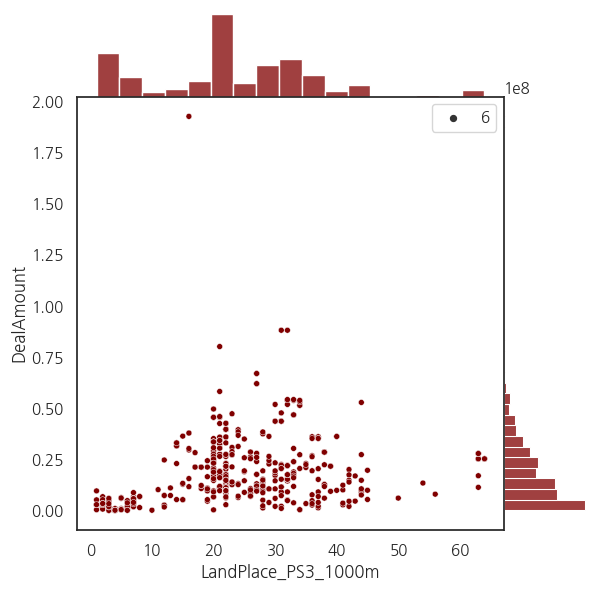

Number Of Missing Point
0
************************************************************
LandPlace_SC4_1000m


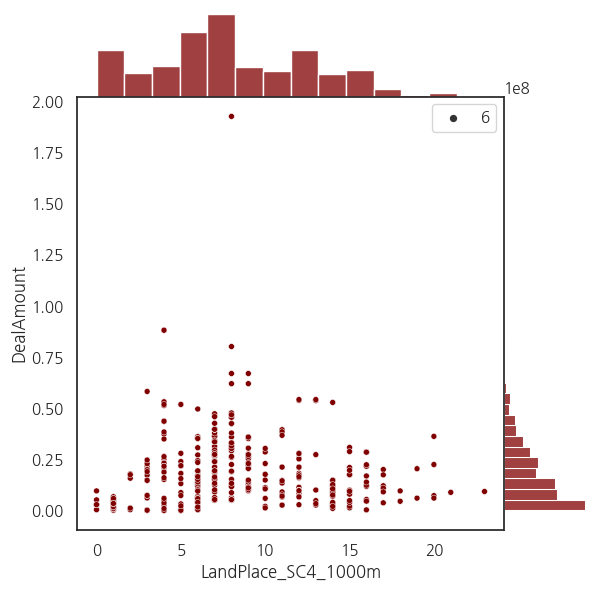

Number Of Missing Point
0
************************************************************
LandPlace_AC5_1000m


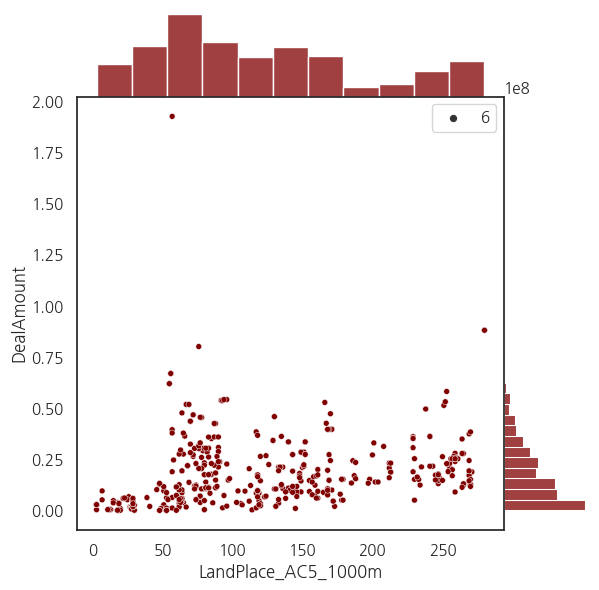

Number Of Missing Point
0
************************************************************
LandPlace_PK6_1000m


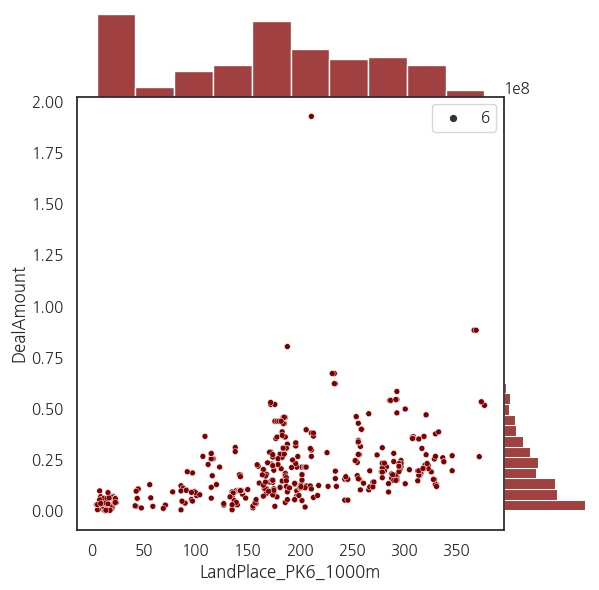

Number Of Missing Point
0
************************************************************
LandPlace_OL7_1000m


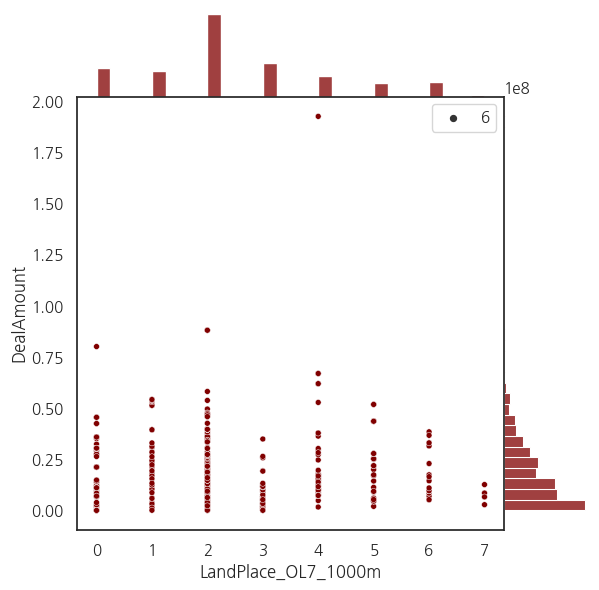

Number Of Missing Point
0
************************************************************
LandPlace_SW8_1000m


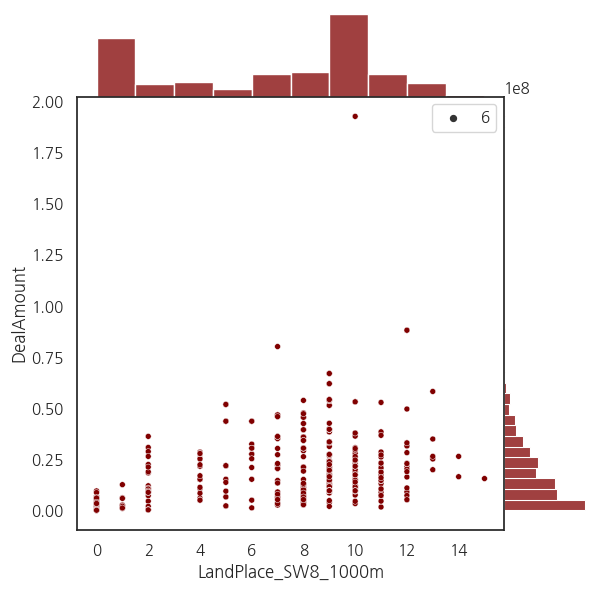

Number Of Missing Point
0
************************************************************
LandPlace_BK9_1000m


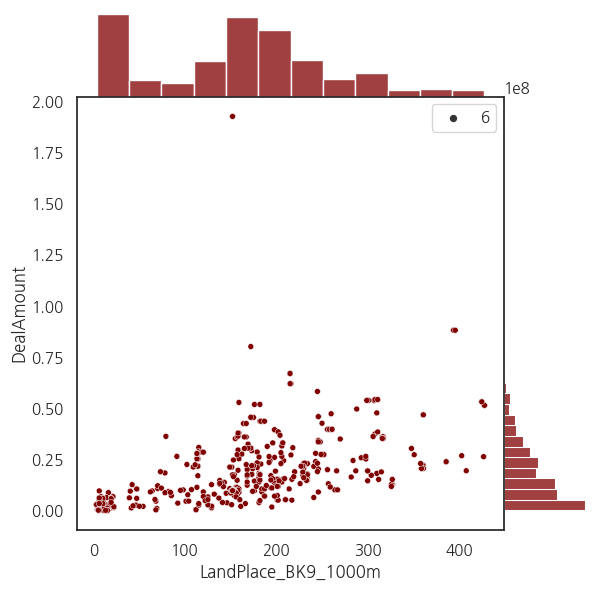

Number Of Missing Point
0
************************************************************
LandPlace_CT1_1000m


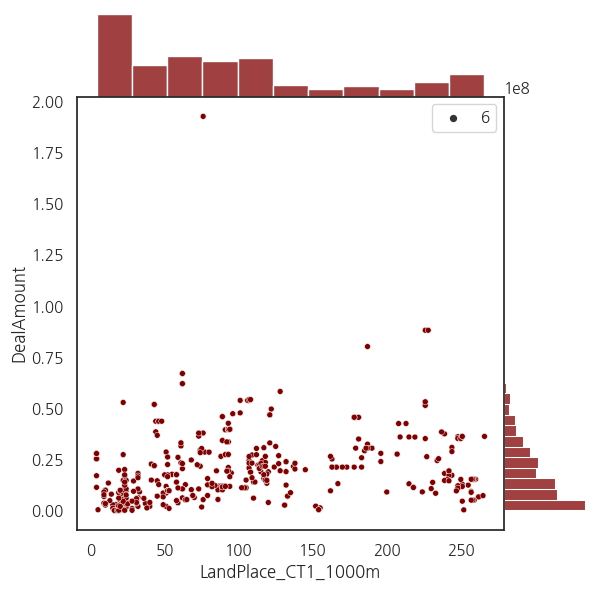

Number Of Missing Point
0
************************************************************
LandPlace_AG2_1000m


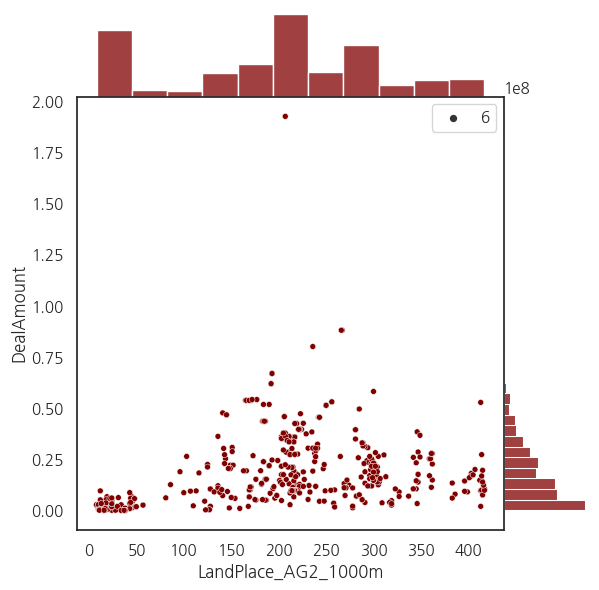

Number Of Missing Point
0
************************************************************
LandPlace_PO3_1000m


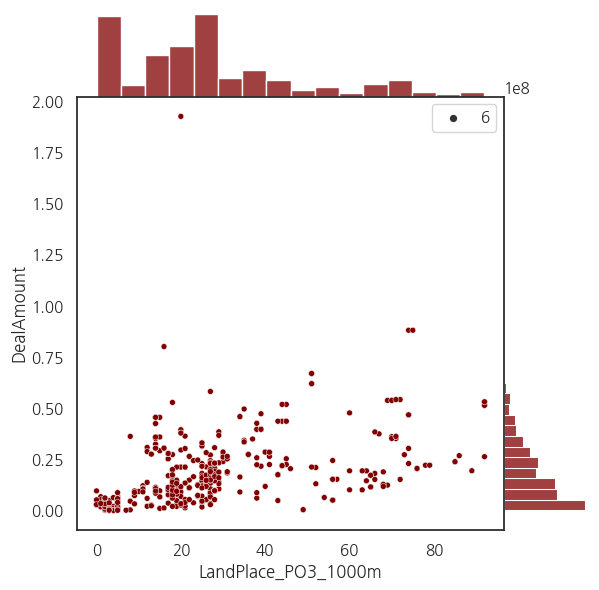

Number Of Missing Point
0
************************************************************
LandPlace_AT4_1000m


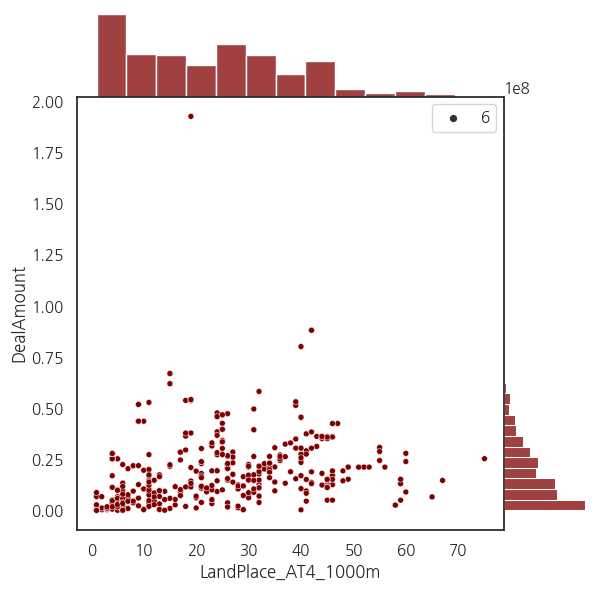

Number Of Missing Point
0
************************************************************
LandPlace_AD5_1000m


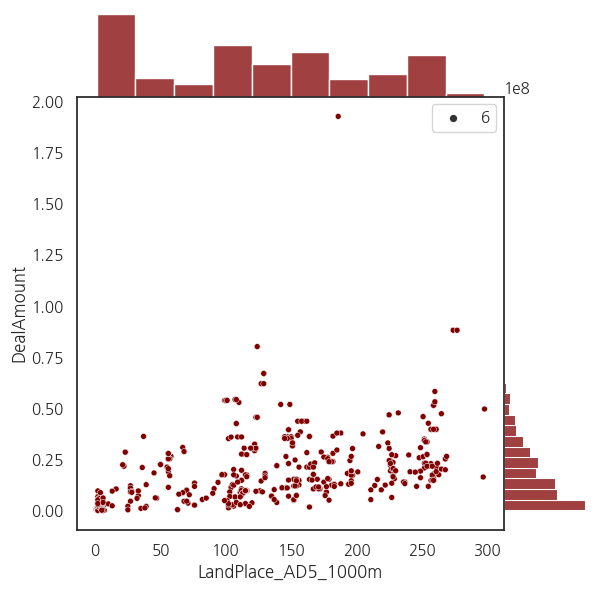

Number Of Missing Point
0
************************************************************
LandPlace_FD6_1000m


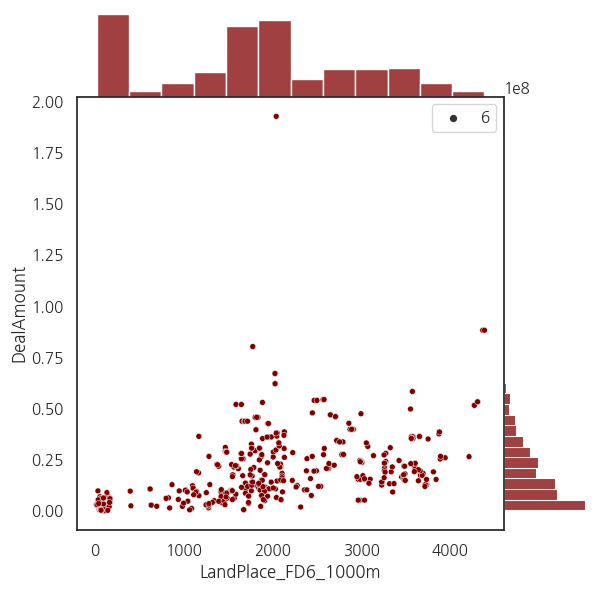

Number Of Missing Point
0
************************************************************
LandPlace_CE7_1000m


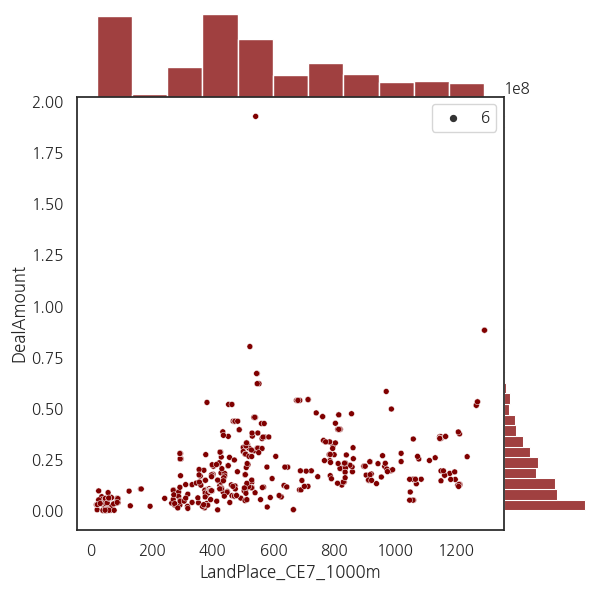

Number Of Missing Point
0
************************************************************
LandPlace_HP8_1000m


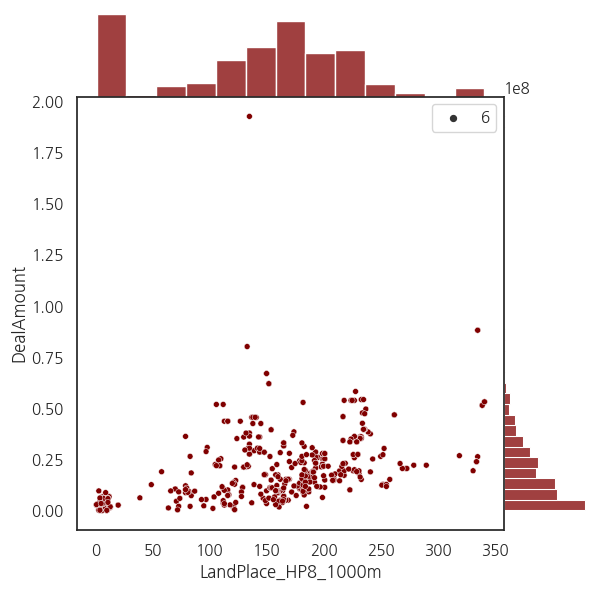

Number Of Missing Point
0
************************************************************
LandPlace_PM9_1000m


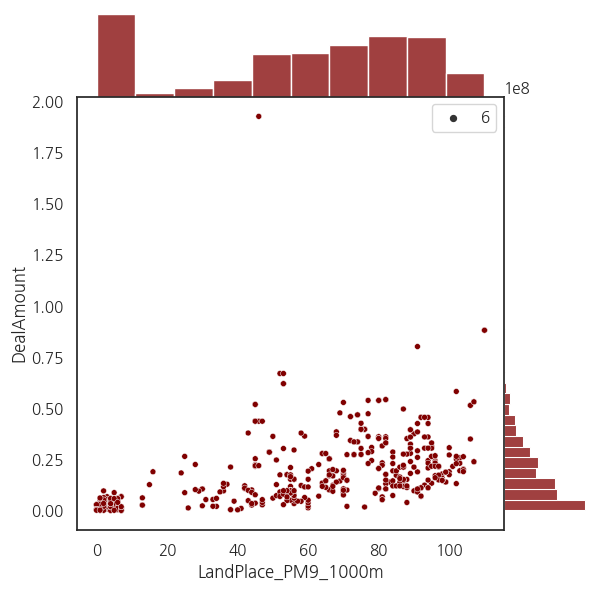

Number Of Missing Point
0
************************************************************
LandPlace_MT1_3000m


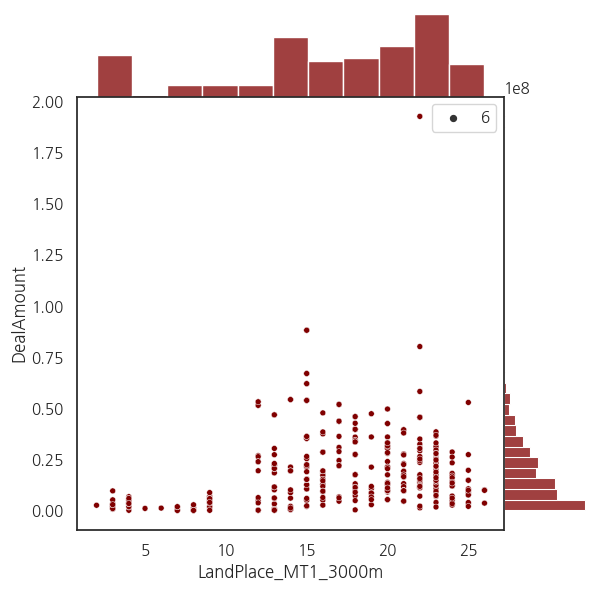

Number Of Missing Point
0
************************************************************
LandPlace_CS2_3000m


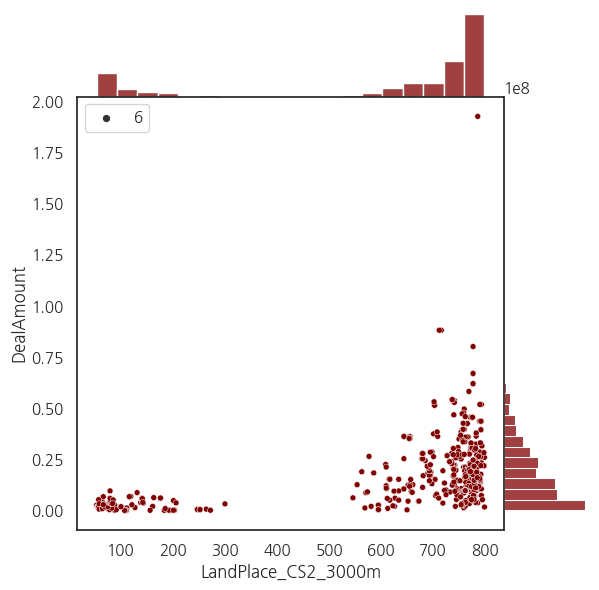

Number Of Missing Point
0
************************************************************
LandPlace_PS3_3000m


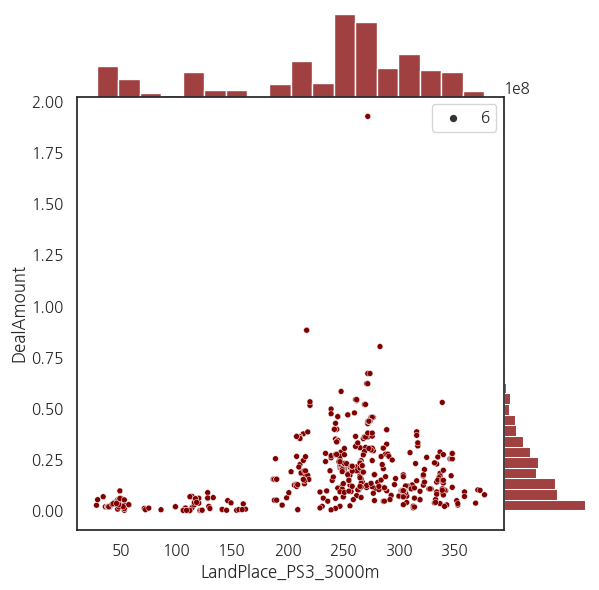

Number Of Missing Point
0
************************************************************
LandPlace_SC4_3000m


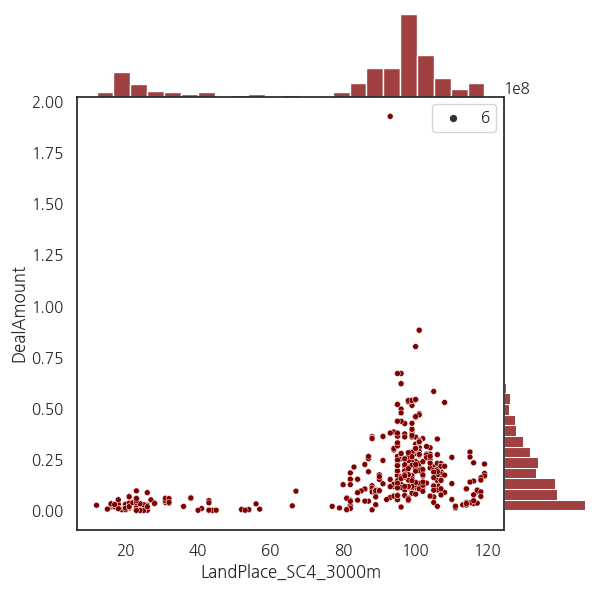

Number Of Missing Point
0
************************************************************
LandPlace_AC5_3000m


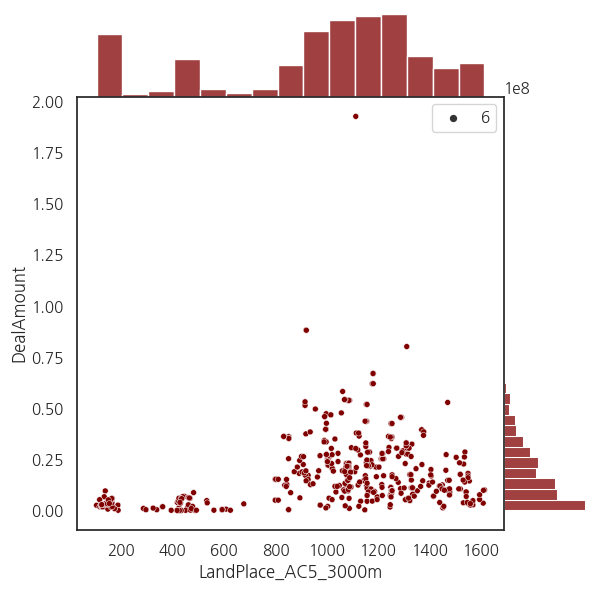

Number Of Missing Point
0
************************************************************
LandPlace_PK6_3000m


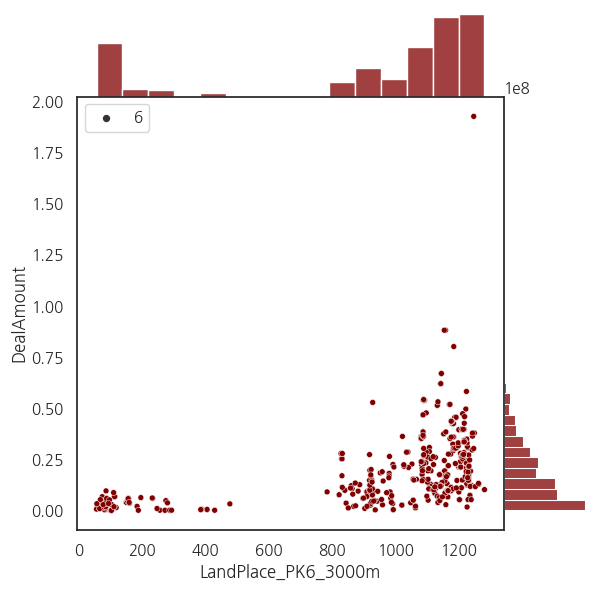

Number Of Missing Point
0
************************************************************
LandPlace_OL7_3000m


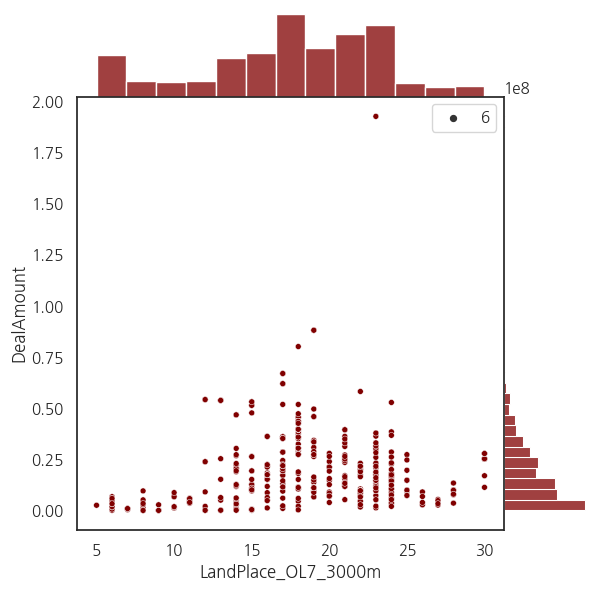

Number Of Missing Point
0
************************************************************
LandPlace_SW8_3000m


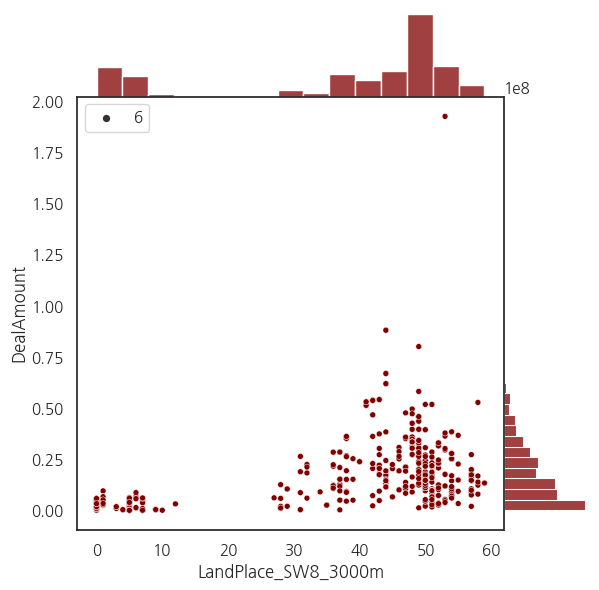

Number Of Missing Point
0
************************************************************
LandPlace_BK9_3000m


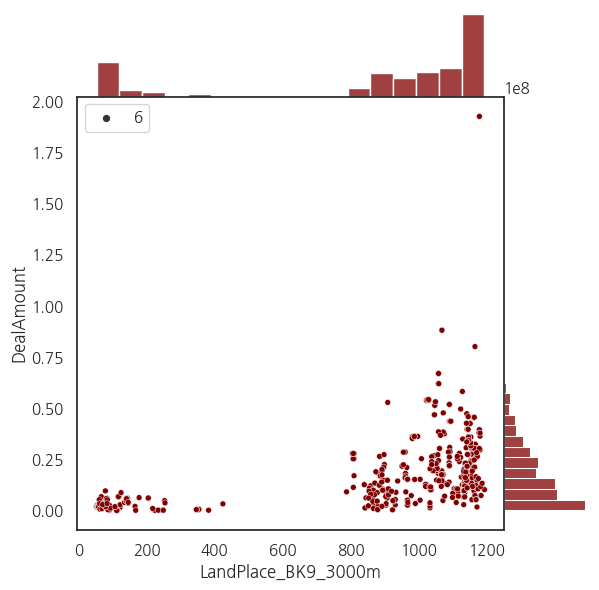

Number Of Missing Point
0
************************************************************
LandPlace_CT1_3000m


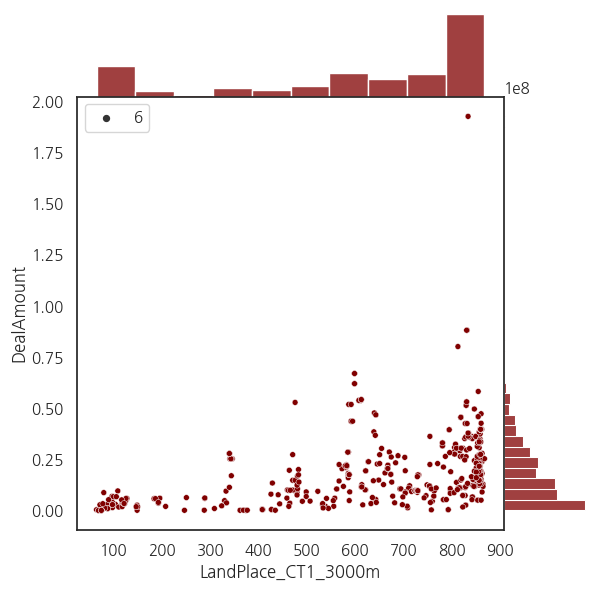

Number Of Missing Point
0
************************************************************
LandPlace_AG2_3000m


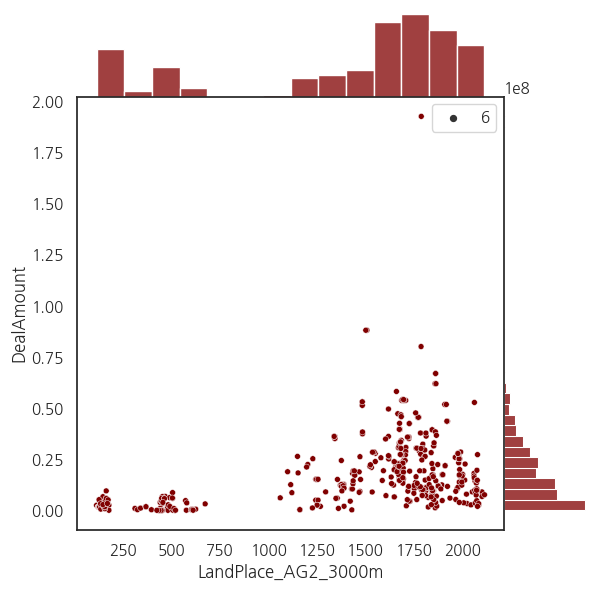

Number Of Missing Point
0
************************************************************
LandPlace_PO3_3000m


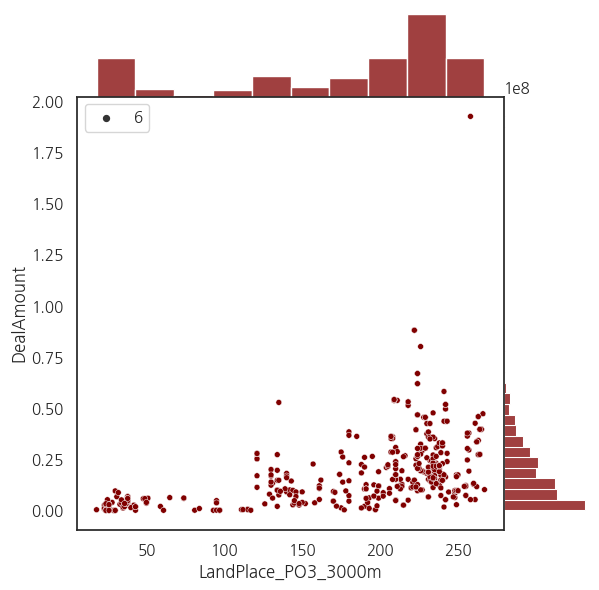

Number Of Missing Point
0
************************************************************
LandPlace_AT4_3000m


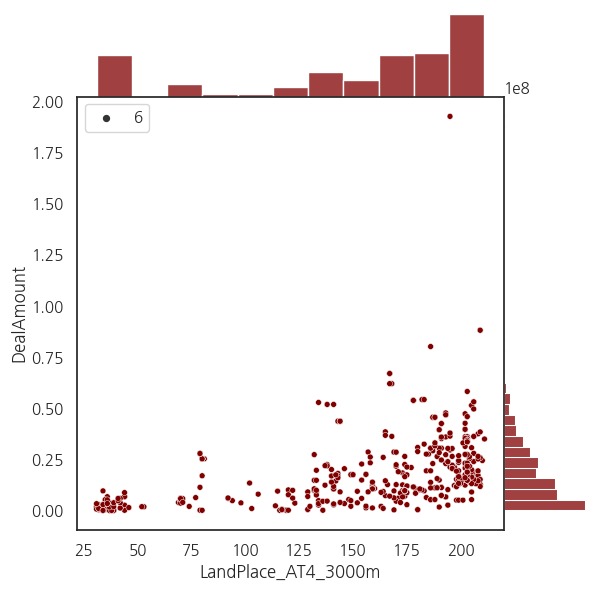

Number Of Missing Point
0
************************************************************
LandPlace_AD5_3000m


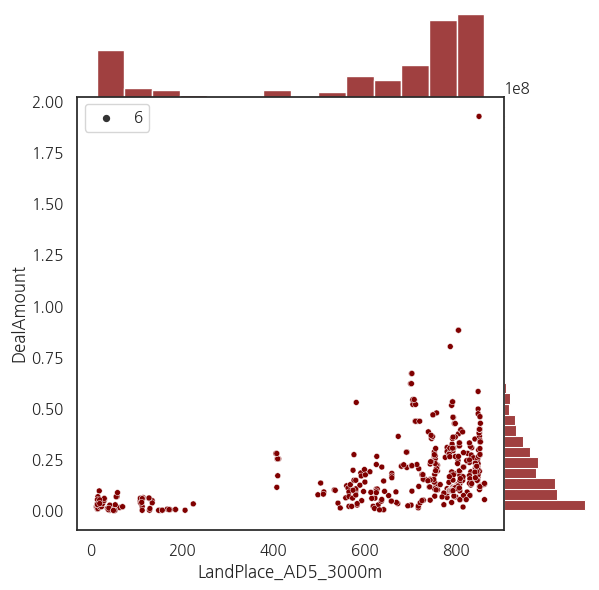

Number Of Missing Point
0
************************************************************
LandPlace_FD6_3000m


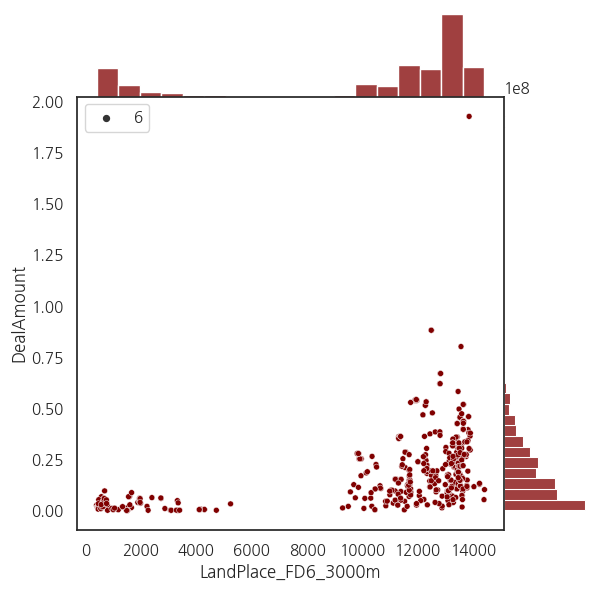

Number Of Missing Point
0
************************************************************
LandPlace_CE7_3000m


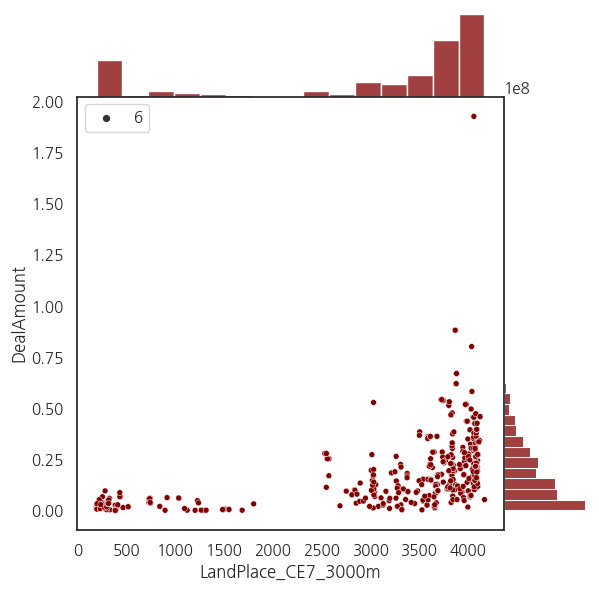

Number Of Missing Point
0
************************************************************
LandPlace_HP8_3000m


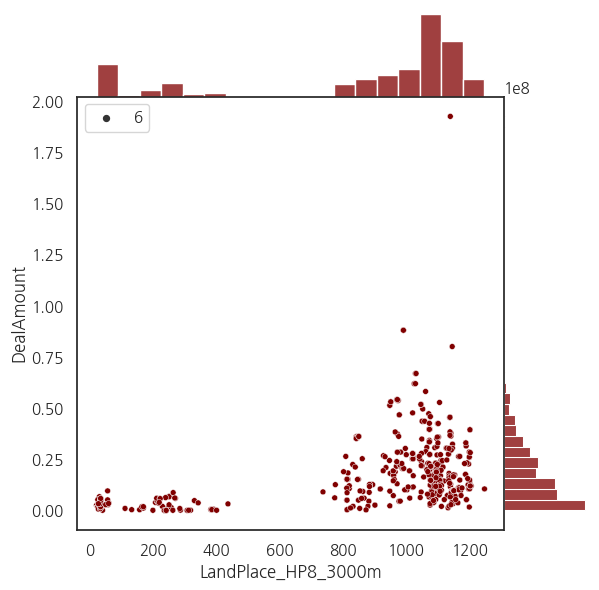

Number Of Missing Point
0
************************************************************
LandPlace_PM9_3000m


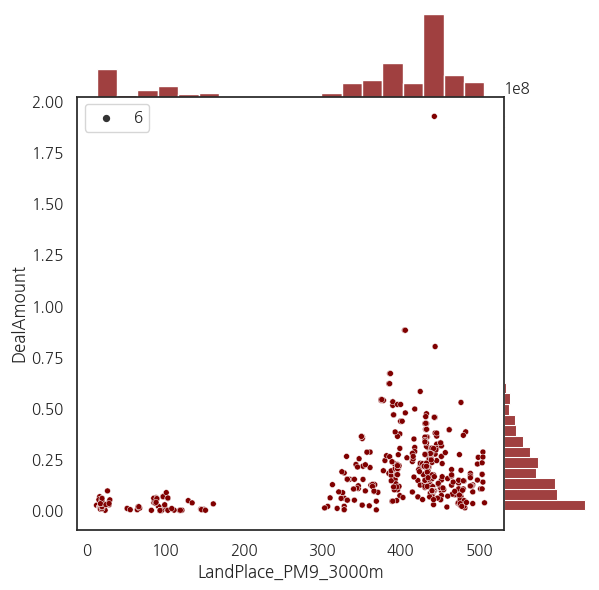

Number Of Missing Point
0
************************************************************


In [12]:
for var in numerical:
    print(var)
    sns.jointplot(
        x=var, 
        y="DealAmount", 
        data=df, 
        size=6, 
        kind="scatter",
        color='#800000', 
        space=0
    )
    #print('Correlation:',pearsonr(data[column], data[ycolumn])[0])
    #ax.set_ylabel(ycolumn)
    plt.show()
    print('Number Of Missing Point')
    print(df[var].isna().sum())
    print('**'*30)

## **Data preprocessing**

In [13]:
# 결측치 제거
origin_d = df.isnull().sum()  # 결측치 개수 확인
df = df.dropna()
df = df.reset_index(drop=True)
remove_d = df.isnull().sum()  # 결측치 제거 확인
for k in origin_d.keys():
    print("{:26s} | {:6d} -> {:26s} | {:6d}".format(k, origin_d[k], k, remove_d[k]))

Sido                       |      0 -> Sido                       |      0
Sigungu                    |      0 -> Sigungu                    |      0
Eupmyeondong               |      0 -> Eupmyeondong               |      0
Ri                         |      0 -> Ri                         |      0
DealAmount                 |      0 -> DealAmount                 |      0
DealMonth                  |      0 -> DealMonth                  |      0
RegstrSeCodeNm             |      0 -> RegstrSeCodeNm             |      0
Year                       |      0 -> Year                       |      0
LndcgrCodeNm               |      0 -> LndcgrCodeNm               |      0
LndpclAr                   |      0 -> LndpclAr                   |      0
PrposAreaNm                |      0 -> PrposAreaNm                |      0
LadUseSittnNm              |      0 -> LadUseSittnNm              |      0
TpgrphHgCodeNm             |      0 -> TpgrphHgCodeNm             |      0
TpgrphFrmCodeNm          

In [14]:
# 범주형 변수에 대한 One-Hot Encoding
categorical.remove("PrposAreaDstrcCodeNm")  # 토지 이용 상황은 하나의 cell에 범주 값이 여러개 존재하기 때문에, 다른 방식으로 처리해준다.

df = pd.get_dummies(data=df, columns=categorical)  # One-Hot Encoding

# 토지이용계획에 대한 
land_uses_iter = (set(x.split(",")) for x in df["PrposAreaDstrcCodeNm"])
land_uses_set = sorted(set.union(*land_uses_iter))
land_uses_mat = pd.DataFrame(np.zeros((len(df), len(land_uses_set))), columns=land_uses_set)
for i in notebook.tqdm(range(len(df))):
    land_uses_mat.loc[i, df["PrposAreaDstrcCodeNm"][i].split(",")] = 1
df = df.join(land_uses_mat.add_prefix("LandUses_"))
df.drop(["PrposAreaDstrcCodeNm"], axis=1, inplace=True)

  0%|          | 0/501 [00:00<?, ?it/s]

In [15]:
df

DealAmount  DealMonth  Year  LndpclAr  PblntfPclnd  Tot_ppltn  Avg_age  \
0    37383177.57          1  2021     21.40     22450000       5929    48.60   
1     9592982.46          1  2021      5.70      6440000       4828    44.90   
2    30769230.77          1  2021      5.20     11150000       7453    42.00   
3    28763040.24          1  2021     67.10     11150000       7453    42.00   
4     1286885.25          1  2021     12.20      2544000       4510    49.40   
..           ...        ...   ...       ...          ...        ...      ...   
496   5303030.30          8  2020     19.80      4082000       3981    42.90   
497  11007462.69          8  2020     53.60      5426000       4441    46.80   
498  15990159.90          8  2020     81.30     14100000       1648    47.60   
499  54130158.73          8  2020      6.30     19940000       2053    37.80   
500  54130271.02          8  2020    435.40     19940000       2053    37.80   

     Ppltn_dnsty  Aged_child_idx  Oldage_suprt_per  ...  LandUses_하수도(포함)  \
0        2454.70          542.90             31.70  ...              0.00   
1        8010.40          532.60             25.00  ...              0.00   
2        9533.10          297.80             20.80  ...              0.00   
3        9533.10          297.80             20.80  ...              0.00   
4       14791.00          492.30             31.40  ...              0.00   
..           ...             ...               ...  ...               ...   
496      2720.00          305.30             24.80  ...              0.00   
497      6028.70          485.80             29.10  ...              0.00   
498      2696.40          577.80             29.80  ...              0.00   
499      2176.90           94.10             11.50  ...              0.00   
500      2176.90           94.10             11.50  ...              0.00   

     LandUses_하천(저촉)  LandUses_하천(접함)  LandUses_하천(포함)  LandUses_하천구역(저촉)  \
0               0.00             0.00             0.00               0.00   
1               0.00             0.00             0.00               0.00   
2               0.00             0.00             0.00               0.00   
3               0.00             0.00             0.00               0.00   
4               1.00             1.00             1.00               0.00   
..               ...              ...              ...                ...   
496             0.00             0.00             0.00               0.00   
497             0.00             0.00             0.00               0.00   
498             0.00             0.00             0.00               0.00   
499             0.00             0.00             0.00               0.00   
500             0.00             0.00             0.00               0.00   

     LandUses_하천구역(접함)  LandUses_하천구역(포함)  LandUses_학교(저촉)  LandUses_학교(접함)  \
0                 0.00               0.00             0.00             0.00   
1                 0.00               0.00             1.00             1.00   
2                 0.00               0.00             1.00             1.00   
3                 0.00               0.00             1.00             1.00   
4                 0.00               0.00             1.00             1.00   
..                 ...                ...              ...              ...   
496               0.00               0.00             0.00             0.00   
497               0.00               0.00             0.00             0.00   
498               0.00               0.00             0.00             0.00   
499               0.00               0.00             0.00             0.00   
500               0.00               0.00             0.00             0.00   

     LandUses_학교(포함)  
0               0.00  
1               1.00  
2               1.00  
3               1.00  
4               0.00  
..               ...  
496             0.00  
497             0.00  
498             0.00  
499             

In [16]:
# 연속형 변수에 대한 이상치 제거
# 연속형 변수를 정규분포를 따르는지에 대한 Kolmoogorov-Smirnov Test를 수행
for n in numerical:
    ks_test = kstest(df[n], "norm", args=(df[n].mean(), df[n].var()**0.5))
    print("{:26s}| statistic = {:.8f}, pvalue = {:.8f}".format(n, ks_test.statistic, ks_test.pvalue))

DealAmount                | statistic = 0.14696316, pvalue = 0.00000000
DealMonth                 | statistic = 0.09896168, pvalue = 0.00010073
Year                      | statistic = 0.38280065, pvalue = 0.00000000
LndpclAr                  | statistic = 0.38710164, pvalue = 0.00000000
PblntfPclnd               | statistic = 0.12868375, pvalue = 0.00000011
Tot_ppltn                 | statistic = 0.22453092, pvalue = 0.00000000
Avg_age                   | statistic = 0.15552347, pvalue = 0.00000000
Ppltn_dnsty               | statistic = 0.25570555, pvalue = 0.00000000
Aged_child_idx            | statistic = 0.18439833, pvalue = 0.00000000
Oldage_suprt_per          | statistic = 0.12107342, pvalue = 0.00000074
Juv_suprt_per             | statistic = 0.17257414, pvalue = 0.00000000
Tot_family                | statistic = 0.16279770, pvalue = 0.00000000
Avg_fmember_cnt           | statistic = 0.19897233, pvalue = 0.00000000
Tot_house                 | statistic = 0.22701630, pvalue = 0.0

결과를 확인해보면 연속형 변수 모두 p-value가 낮아(0.00000000) 높은 유의수준에서 귀무가설을 기각함을 확인할 수 있습니다.

it is evident that the p-values for all numerical variables are very low(0.00000000), leading to the rejection of the null hypothesis at a high level of significance.

In [17]:
# Divided train & test dataset
x = df.drop(["DealAmount"], axis=1)
y = df["DealAmount"]

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size = 0.3, random_state = 0)
print('Train Dataset:', train_x.shape, '\nTest Dataset:', test_x.shape)

train_y = train_y.to_numpy().astype(int)
test_y = test_y.to_numpy().astype(int)

Train Dataset: (350, 581) 
Test Dataset: (151, 581)


### **Model Training with XGBoost**

In [18]:
from sklearn.metrics import mean_squared_error
import xgboost as xgb

parameter = {
    'learning_rate':0.22,
    'n_estimators':350,
    'max_depth':9,
    'min_child_weight':1,
    'gamma':0,
    'subsample':0.91,
    'colsample_bytree':0.89,
    'lambda':10,
    'alpha':5,
    'eval_metric':'rmse',
    'seed':0
}
    
model = xgb.XGBRegressor(
    tree_method = 'gpu_hist',
    gpu_id = 0,
    importance_type = 'gain',
    learning_rate = parameter['learning_rate'],
    n_estimators = parameter['n_estimators'], 
    max_depth = parameter['max_depth'],
    min_child_weight = parameter['min_child_weight'],
    gamma = parameter['gamma'],
    subsample = parameter['subsample'],
    colsample_bytree = parameter['colsample_bytree'],
    reg_lambda = parameter['lambda'],
    alpha = parameter['alpha'],
    eval_metric = parameter['eval_metric'],
    seed = parameter['seed']
)

model.fit(train_x, train_y)

XGBRegressor(alpha=5, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.89, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=0, gpu_id=0, grow_policy=None, importance_type='gain',
             interaction_constraints=None, learning_rate=0.22, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=350, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...)

### **Evaluation and Validation**

In [29]:
relation_square = model.score(train_x, train_y)
print("R-Squared: ", relation_square)

predict_y = model.predict(test_x)
#predict_y = np.exp(predict_y_log) - 1
#test_y = np.exp(test_y) - 1
result = pd.DataFrame({'pred' : predict_y, 'real' : test_y})
print("RMSE score: {:,.0f}".format(mean_squared_error(test_y, predict_y) ** 0.5))

result['ratio(%)'] = (abs(result['pred'] - result['real']) / result['real']) * 100

R-Squared:  0.99998670085339
RMSE score: 15,995,076


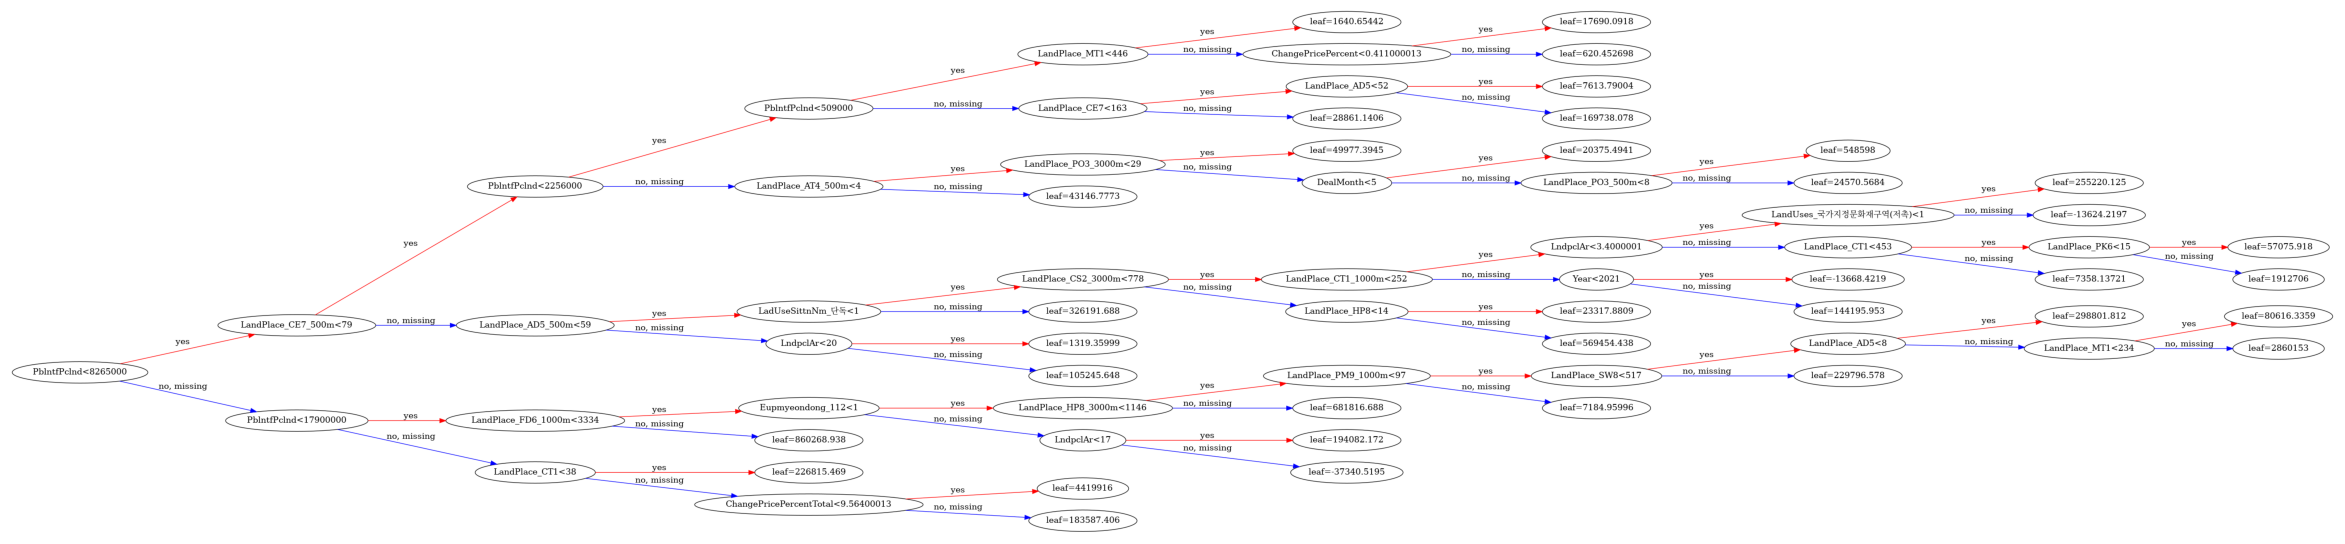

In [20]:
# Model visualization
fig, ax = plt.subplots(figsize=(30, 200))
xgb.plot_tree(model, num_trees=4, rankdir='LR', ax=ax)
plt.show()

In [21]:
print(result.sort_values("ratio(%)"))
for r in [3, 5, 10, 20]:
    print("ratio < {:2d}%: {:5d} / {:5d} ({:4.2f}%)".format(
        r, len(result[result["ratio(%)"] < r]), len(result), len(result[result["ratio(%)"] < r])/len(result)*100
    ))

            pred      real  ratio(%)
88   53042284.00  53042328      0.00
141   6635057.00   6635064      0.00
12   51304408.00  51304347      0.00
2    11072907.00  11072881      0.00
101  11072907.00  11072881      0.00
..           ...       ...       ...
7      387261.06    120521    221.32
21    9088007.00   1694915    436.19
109  29495166.00   5040000    485.22
107  10166064.00    406320   2401.98
81   10126195.00    396694   2452.65

[151 rows x 3 columns]
ratio <  3%:    45 /   151 (29.80%)
ratio <  5%:    51 /   151 (33.77%)
ratio < 10%:    61 /   151 (40.40%)
ratio < 20%:    81 /   151 (53.64%)


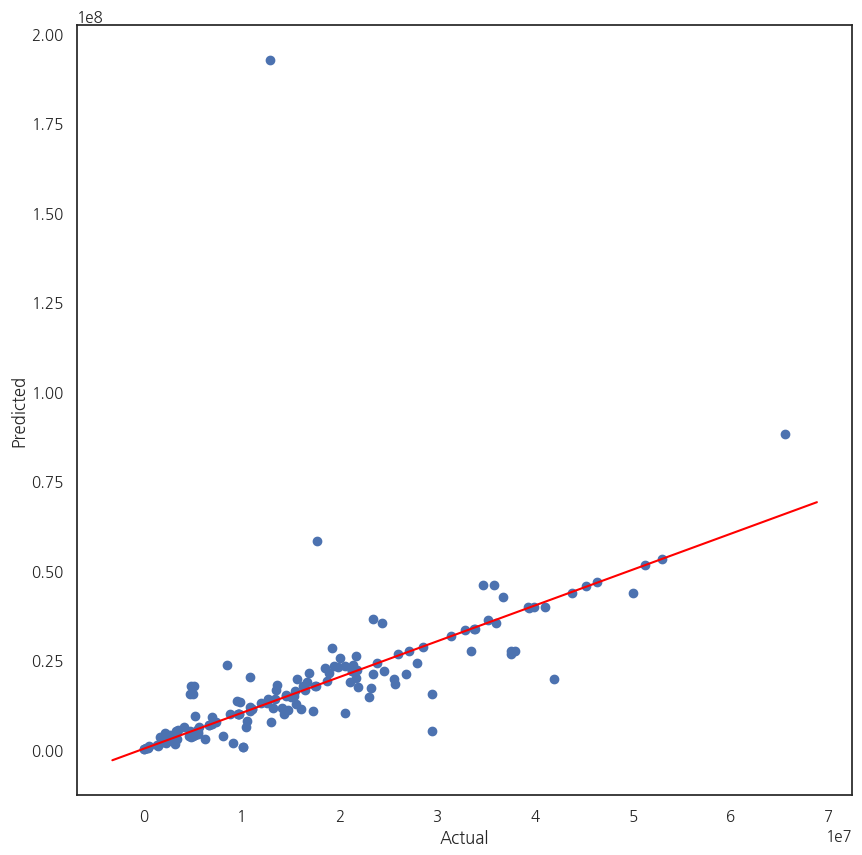

In [22]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(data=result, x="pred", y="real")
ax.set_xlabel("Actual")
ax.set_ylabel("Predicted")
x = np.linspace(*ax.get_xlim())
ax.plot(x, x,color='red')
plt.show()

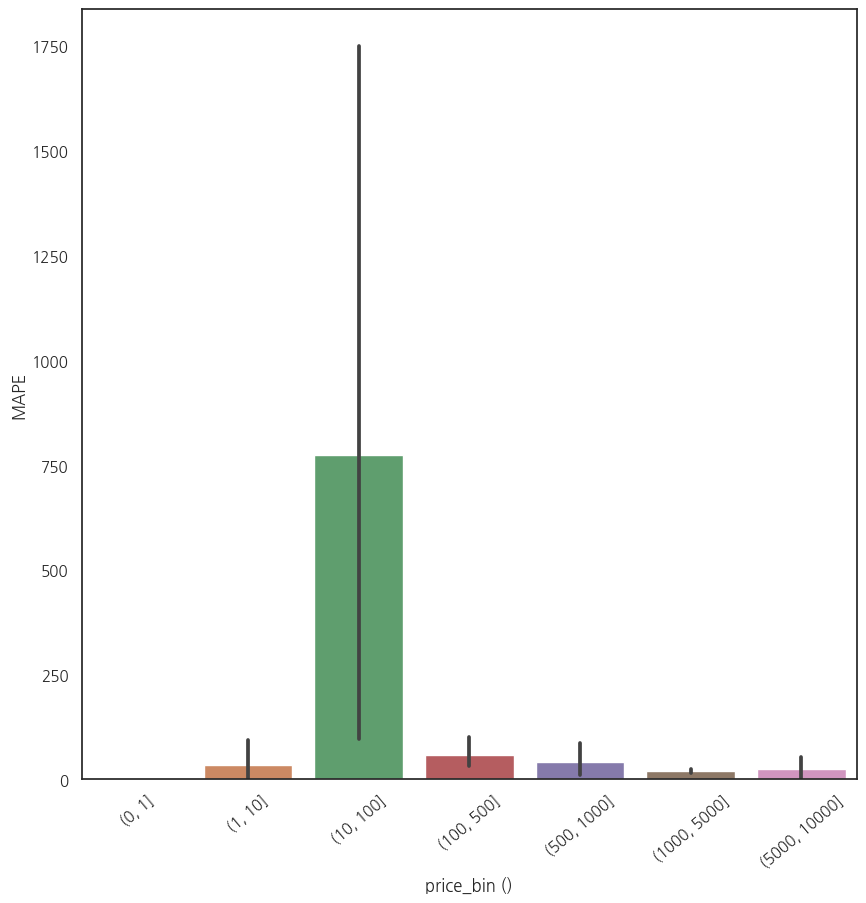

In [23]:
price_bin = pd.cut(test_y/10000,bins=[0,1,10,100,500,1000,5000,10000])
mape = result["ratio(%)"]

fig,ax = plt.subplots(1,figsize=(10,10))
sns.barplot(x=price_bin, y=mape)
ax.set_ylabel('MAPE')
ax.set_xlabel('price_bin ()')
plt.xticks(rotation=40)
plt.show()

In [24]:
price_bin

[(1000, 5000], (500, 1000], (1000, 5000], (1000, 5000], (1000, 5000], ..., (1000, 5000], (1000, 5000], (100, 500], (100, 500], (1000, 5000]]
Length: 151
Categories (7, interval[int64, right]): [(0, 1] < (1, 10] < (10, 100] < (100, 500] < (500, 1000] < (1000, 5000] < (5000, 10000]]

<Axes: xlabel='ratio(%)', ylabel='Density'>

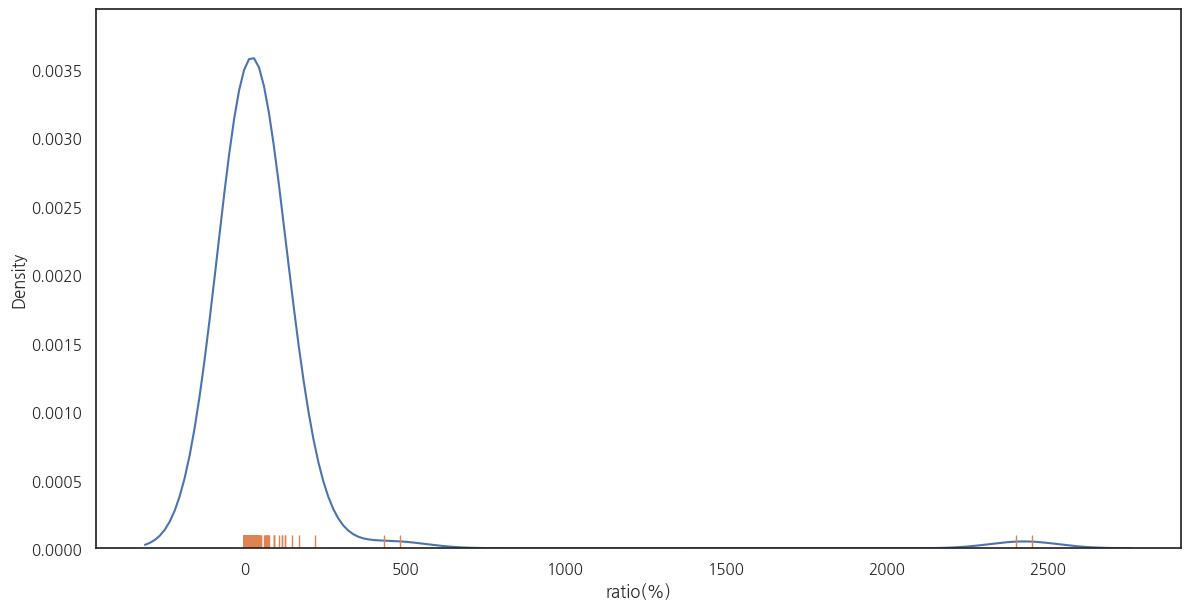

In [25]:
fig = plt.subplots(figsize=(14, 7))
sns.kdeplot(result["ratio(%)"])
sns.rugplot(result["ratio(%)"])

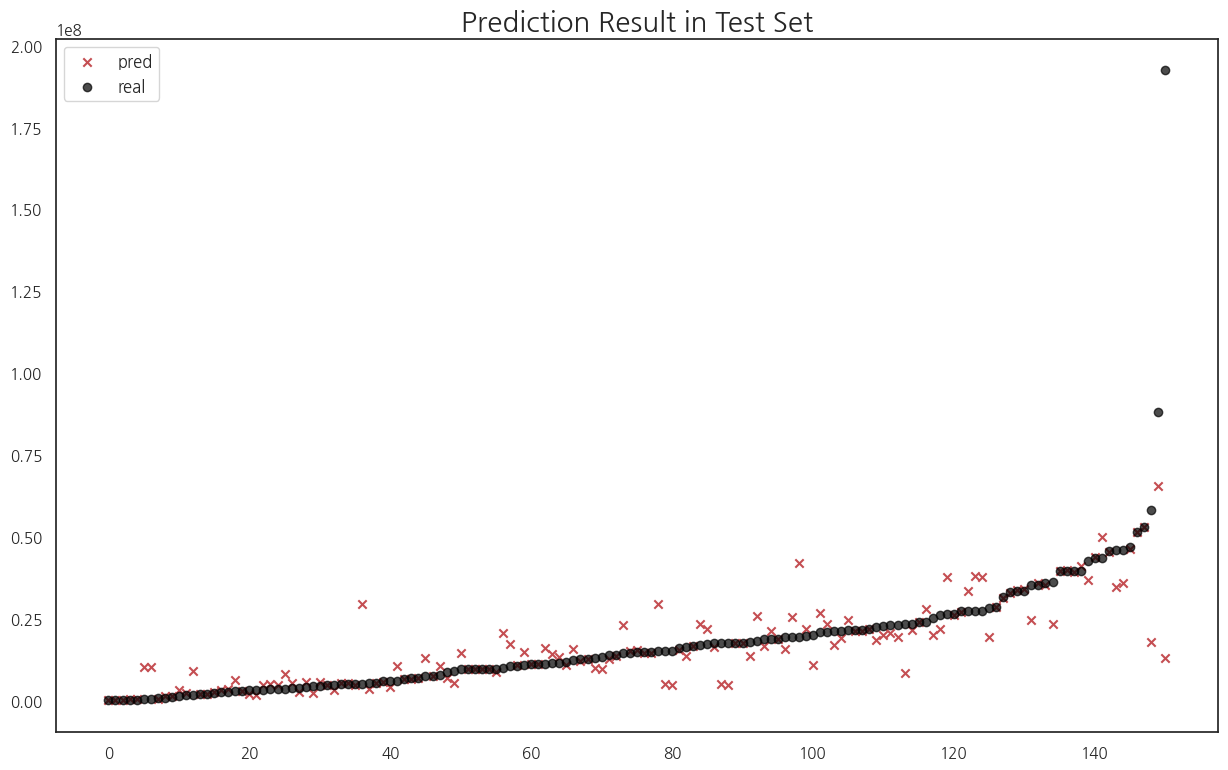

In [26]:
result = result.sort_values(by='real').reset_index(drop=True)

plt.figure(figsize=(15, 9))
plt.scatter(result.index, result['pred'], marker='x', color='r')
plt.scatter(result.index, result['real'], alpha=0.7, marker='o', color='black')
plt.title("Prediction Result in Test Set", fontsize=20)
plt.legend(['pred', 'real'], fontsize=12)
plt.show()